<a href="https://colab.research.google.com/github/Ryandry1st/Carrier-Frequency-Offset/blob/master/Research_CFO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Initial Setup

##Extra stuff

In [0]:
!nvidia-smi

Fri Feb 14 04:56:57 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.48.02    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
# Detect hardware 
import sys
if 'google.colab' in sys.modules: # Colab-only Tensorflow version selector
  %tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version " + tf.__version__)
      
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
except ValueError:
  tpu = None
  gpus = tf.config.experimental.list_logical_devices("GPU")
    
# Select appropriate distribution strategy for hardware
if tpu:
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.experimental.TPUStrategy(tpu)
  print('Running on TPU ', tpu.master())  
elif len(gpus) > 0:
  strategy = tf.distribute.MirroredStrategy(gpus) # this works for 1 to multiple GPUs
  print('Running on ', len(gpus), ' GPU(s) ')
else:
  strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  print('Running on CPU')

# How many accelerators do we have ?
print("Number of accelerators: ", strategy.num_replicas_in_sync)

TensorFlow 2.x selected.
Tensorflow version 2.1.0
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Running on  1  GPU(s) 
Number of accelerators:  1


In [0]:
from google.colab import drive
from google.colab import files

drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!ls drive/'My Drive'/'Colab Notebooks_UT'/CFO

Models	MSES


# Basic Functions

In [0]:
!pip install spectrum

import numpy as np
import matplotlib
import scipy.signal
from spectrum import pmusic
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import GradientBoostingClassifier
from scipy.fftpack import fft


## set up plotting
matplotlib.rcParams['figure.figsize'] = [14, 10]


################################# Data Generation #################################################
def data_generator(min_fc, max_fc, phase_offset=0, amplitude = 1, n=24, fs=4000):
    """
    Generates data which has a carrier frequency between min_fc and max_fc
    :param min_fc: minimum fc possible
    :param max_fc: maximum fc possible
    :param n: number of points to generate
    :param phase_offset: The desired phase offset in degrees
    :param fs: The sampling frequency in Hertz for calculating digital frequency
    :return: One set of data with fc randomly between min_fc and max_fc of size n, and the digital frequency
    """
    fc = np.random.uniform(min_fc, max_fc)
    digital_freq = fc/fs
    tend = n/fs
    t = np.arange(0, n)/fs
    x = amplitude*np.exp(1j*(2*np.pi*fc*t + phase_offset/180*np.pi))

    return x, digital_freq


def generate_noise(data, snr=20):
    """
    generates noisy data from clean data and a signal to noise ratio
    :param data: clean input data
    :param snr: Signal to Noise ratio in dB
    :return: noisy data
    """
    sig_power = 1.0/len(data)*np.dot(data.conj().T, data).real
    sig_power_db = 10*np.log10(sig_power)
    noise_power_db = sig_power_db - snr
    noise_power = 10**(noise_power_db/10.0)
    std = np.sqrt(noise_power/2.0)
    noise_comp = np.random.normal(loc=0, scale=std, size=(len(data), 2)).astype(np.float64)

    noise = np.complex128(noise_comp[:, 0] + 1j * noise_comp[:, 1])
    noisy_data = np.add(data, noise).astype(np.complex128)

    return noisy_data, std


def convert_complex_to_real(data):
    """
    Converts complex vector data into a matrix with two seperate real values
    """
    new_data = np.zeros((len(data), 2))
    new_data[:, 0] = data.real
    new_data[:, 1] = data.imag
    return new_data

def convert_real_to_complex(data):
    """
    Converts a matrix of real data into a single vector with complex data
    """
    new_data = np.zeros((len(data)))
    new_data = data[:, 0] + j*data[:, 1]
    return new_data


def build_dataset(min_fc, max_fc, size, fs, amplitude=1, n=24, phase_offset=None, min_snr=None, max_snr=None, split_real_imag=False, quantizer=None):
    """
    Generates a dataset with noise over many frequencies
    :param min_fc: Minimum carrier frequency in Hertz
    :param max_fc: Maximum carrier frequency in Hertz
    :param size: Number of different data generations to run
    :param fs: Sampling frequency in Hertz
    :param amplitude: Amplitude of the signals before noise
    :param n: Number of samples per data generation
    :param phase_offset: None, otherwise randomly generated phase offset in data from 0 to 360 degrees
    :param noise_snr: None for clean data or the SNR of noisy data to generate with
    :param split_real_imag: Whether the returned data should be complex or two real sets
    :return: dataset(size, n, ?), digital frequencies
    """
    dataset = np.zeros((size, n), dtype=np.complex128)
    frequencies = np.zeros((size, n), dtype=np.float64)
    for i in range(size):
        # random phase offset
        if phase_offset is not None:
            offset = np.random.randint(0, 360)
            dataset[i], frequencies[i, :] = data_generator(min_fc=min_fc, max_fc=max_fc, phase_offset=offset, amplitude=amplitude, n=n, fs=fs)
        else:
            dataset[i], frequencies[i, :] = data_generator(min_fc=min_fc, max_fc=max_fc, amplitude=amplitude, n=n, fs=fs)
            
        if min_snr is not None:
            noise_snr = np.random.uniform(low=min_snr, high=max_snr, size=1)
            dataset[i], _ = generate_noise(dataset[i], noise_snr)
            
        if quantizer is not None:
            dataset[i][:], _ = general_quantizer(data=dataset[i][:], minimum=-amplitude, maximum=amplitude, bits=1)

    if split_real_imag != False:
        newdataset = np.zeros((size, n, 2))
        for i in range(size):
            newdataset[i, :, :] = convert_complex_to_real(dataset[i, :])

        dataset = newdataset
        
    return (dataset, frequencies)


################################### Quantizer Functions #################################################
def general_quantizer(data, minimum=-1, maximum=1, bits=1, quantizer_func=None):
    """
    Generic quantizer function to call other quantizer functions
    :param data: Time domain input data
    :param minimum: Minimum input data value
    :param maximum: Maximum input data value
    :param bits: Number of bits for the quantizer
    :param quantizer_func: The function which will generate the quantizer levels (data, minimum, maximum, bits)
    :return: (quantized data, quantizer levels)
    """
    data = np.asarray(data)
    if quantizer_func is None:
        levels = np.asarray(linear_quantizer(data=data, minimum=minimum, maximum=maximum, bits=bits))
    else:
        try:
            levels = np.asarray(quantizer_func(data=data, minimum=minimum, maximum=maximum, bits=bits))
        except Exception as e:
            print("Non-linear function not given, switching to linear")
            levels = linear_quantizer(data=data, minimum=minimum, maximum=maximum, bits=bits)

    quantized_data = np.zeros_like(data)
    # determine if data is real, complex
    if isinstance(data, np.complex128) or isinstance(data, complex):
        for t, amplitude in enumerate(data):
            idx = (np.abs(levels - amplitude)).argmin()
            quantized_data[t] = levels[idx]

    else:
        quantized_data = np.zeros((len(data), 2))

        for t, amplitude in enumerate(data.real):
            idx = (np.abs(levels - amplitude)).argmin()
            quantized_data[t][0] = levels[idx]
        for t, amplitude in enumerate(data.imag):
            idx = (np.abs(levels - amplitude)).argmin()
            quantized_data[t][1] = levels[idx]

        quantized_data = np.add(quantized_data[:, 0], 1j * quantized_data[:, 1])

    return quantized_data, levels


def linear_quantizer(data, minimum=1, maximum=1, bits=1):
    """
    A simple linear quantizer giving even spaced levels between min and max
    :param data: time domain input data
    :param minimum: minimum level desired
    :param maximum: Non-inclusive maximum level desired
    :param bits: number of bits used
    :return: linear levels for the quantizer
    """
    levels = np.linspace(minimum, maximum, 2**bits)
    return levels


def non_linear_quantizer(data, minimum=-1, maximum=1, bits=1):
    """
    Non-linear quantizer, can be redone for more advanced algorithms, currently is a linear of the inner 1/2 of the range
    :param data: Time domain input data
    :param minimum: Minimum quantizer input
    :param maximum: Maximum quantizer input
    :param bits: Number of bits to use
    :return: quantizer levels
    """
    scale = maximum - minimum
    levels = np.zeros(2**bits)
    if bits > 2:
        adj_min = minimum + scale/4
        adj_max = maximum - scale/4
        levels[0] = adj_min
        levels[1:] = np.linspace(adj_min, adj_max, 2**bits-1)
        levels[-1] = adj_max
    return levels


###################################### General Signal Processing #############################################
def plot_over_snr(data, snr_min, snr_max, fs, min_fc, max_fc, estimators=None, names=None, phase=None, quantizer=None, bits=1, monte_carlos=1):
    """
    Plots the estimator performance over a range of SNR values
    :param data: Time domain, ideal data
    :param snr_min: Minimum SNR value to test
    :param snr_max: Maximum SNR value to test
    :param fs: Sampling frequency
    :param min_fc: Minimum carrier frequency in Hertz
    :param max_fc: Maximum carrier frequency in Hertz
    :param estimators: List of estimator function taking (data, fs)
    :param names: List of names of the estimators
    :param quantizer: None, or else applies the linear quantizer
    :param phase: None, or applies uniformly distributed phase offset
    :param bits: number of bits for the quantizer to use
    :param Monte_Carlos: Number of simulations to run and average over
    :return: SNRs used and the MSE for the estimators
    """

    snrs = np.linspace(snr_min, snr_max, (snr_max-snr_min)*2)
    amplitude = np.max(np.absolute(data))

    plt.title(f"10*log10(MSE) vs SNR for frequency estimation")
    plt.xticks(np.arange(snr_min, snr_max+1e-8, step=(snr_max-snr_min)/5))
    plt.xlabel("SNR (dB)")
    plt.ylabel("10*log10(MSE) (dB)")

    # true_snr = np.zeros((len(snrs), monte_carlos))
    num_estimators = len(estimators)
    fcs = np.zeros((num_estimators, len(snrs), monte_carlos), dtype=np.float64)


    if estimators is not None:
        estimators_predictions = np.zeros((num_estimators, len(snrs), monte_carlos), dtype=np.float64)
        for estimator in range(num_estimators):
            for sim in range(monte_carlos):
                for snr_num, snr in enumerate(snrs):
                    new_data, fcs[estimator, snr_num, sim] = data_generator(min_fc, max_fc, amplitude=amplitude, n=len(data), fs=fs)

                    if phase is not None:
                        phase_shift = np.random.randint(0, 360)
                        new_data, fcs[estimator, snr_num, sim] = data_generator(min_fc, max_fc, phase_offset=phase_shift, amplitude=amplitude, n=len(data), fs=fs)

                    noisy_data, _ = generate_noise(new_data, snr)

                    # true_snr[snr_num, sim] = calc_snr(data, noisy_data)

                    if quantizer is not None:
                        noisy_data, levels = general_quantizer(data=noisy_data, minimum=-amplitude, maximum=amplitude, bits=bits, quantizer_func=quantizer)
                        plt.title(f"10log10(MSE) vs SNR for frequency estimation with {bits}-bit Quanitization")

                    estimators_predictions[estimator, snr_num, sim] = estimators[estimator](data=noisy_data)

    mses = np.zeros((num_estimators, len(snrs)), dtype=np.float64)

    # snrs = [np.average(true_snr[i, :]) for i in range(len(snrs))]
    snrs_lin = [10.0**(snrs[i]/10.0) for i in range(len(snrs))]

    for estimator in range(num_estimators):
        for snr_num, snr in enumerate(snrs):
            # calculate MSE for each estimator at each SNR
            mses[estimator][snr_num] = np.float64(mean_squared_error(fcs[estimator, snr_num, :], estimators_predictions[estimator, snr_num, :]))
            # apply 10log(mse) for each estimator at each SNR
            mses[estimator][snr_num] = np.float64(10.0 * np.log10((mses[estimator][snr_num])))
        plt.plot(snrs, mses[estimator], '--')

    if quantizer is None:
        CRB = np.zeros(len(snrs))
        CRB = [6.0/(snrs_lin[i] * (len(data) * (len(data)**2 - 1))) for i in range(len(snrs))]
        CRB = [-16.5 + 10.0 * np.log10((CRB[i])) for i in range(len(CRB))]

        plt.plot(snrs, CRB)
        names.append("CRB")

    plt.xticks(np.arange(snr_min, snr_max+1.0e-5, step=0.1*(snr_max-snr_min)))
    plt.legend(names, loc='best')
    plt.grid()
    plt.show()
    return (snrs, mses)


def plot_over_snr_DL(data, snr_min, snr_max, fs, min_fc, max_fc, estimators=None, phase=None, names=None, quantizer=None, bits=1, monte_carlos=1):
    """
    Plots the estimator performance over a range of SNR values
    :param data: Time domain, ideal data
    :param snr_min: Minimum SNR value to test
    :param snr_max: Maximum SNR value to test
    :param fs: Sampling frequency
    :param min_fc: Minimum carrier frequency in Hertz
    :param max_fc: Maximum carrier frequency in Hertz
    :param estimators: List of estimator function taking (data, fs)
    :param names: List of names of the estimators
    :param quantizer: None, or else applies the linear quantizer
    :param phase: None, or applies uniformly distributed phase offset
    :param bits: number of bits for the quantizer to use
    :param Monte_Carlos: Number of simulations to run and average over
    :return: SNRs used and the MSE for the estimators
    """

    snrs = np.linspace(snr_min, snr_max, (snr_max-snr_min)*2)
    amplitude = np.max(np.absolute(data))

    plt.title(f"10*log10(MSE) vs SNR for frequency estimation")
    plt.xticks(np.arange(snr_min, snr_max+1e-8, step=(snr_max-snr_min)/5))
    plt.xlabel("SNR (dB)")
    plt.ylabel("10*log10(MSE) (dB)")

    noisy_data = np.zeros((len(snrs), monte_carlos, len(data)))
    fcs = np.zeros((len(snrs), monte_carlos), dtype=np.float64)
    
    if estimators is not None:
        num_estimators = len(estimators)
        estimators_predictions = np.zeros((num_estimators, len(snrs), monte_carlos))
        # gather all data first for DL
        for sim in range(monte_carlos):
            for snr_num, snr in enumerate(snrs):
                new_data, fcs[snr_num, sim] = data_generator(min_fc, max_fc, amplitude=amplitude, n=len(data), fs=fs)

                if phase is not None:
                    phase_shift = np.random.randint(0, 360)
                    new_data, fcs[snr_num, sim] = data_generator(min_fc=min_fc, max_fc=max_fc, phase_offset=phase_shift, amplitude=amplitude, n=len(data), fs=fs)

                noisy_data[snr_num, sim, :], _ = generate_noise(new_data, snr)

                if quantizer is not None:
                    noisy_data[snr_num, sim, :], levels = general_quantizer(data=noisy_data[snr_num, sim, :], minimum=-amplitude, maximum=amplitude, bits=bits, quantizer_func=quantizer)
                    plt.title(f"10log10(MSE) vs SNR for frequency estimation with {bits}-bit Quanitization")

    mses = np.zeros((num_estimators, len(snrs)))
 
    for estimator in range(num_estimators):
        for snr_num, snr in enumerate(snrs):
            # calculate MSE for each estimator at each SNR
            mses[estimator][snr_num] = mean_squared_error(fcs[snr_num, :], estimators[estimator](noisy_data[snr_num, :, :]))
            # apply 10log(mse) for each estimator at each SNR
            mses[estimator][snr_num] = np.float64(10.0 * np.log10((mses[estimator][snr_num])))
        plt.plot(snrs, mses[estimator], '--')


    plt.xticks(np.arange(snr_min, snr_max+1.0e-5, step=0.1*(snr_max-snr_min)))
    plt.legend(names, loc='best')
    plt.grid()
    plt.show()
    return (snrs, mses)


def calc_snr(clean_data, noisy_data):
    """
     Calculates the SNR from a clean data and noisy data set
    :param clean_data: time domain data without noise
    :param noisy_data: time domain data with noise
    :return: Signal to Noise ratio
    """
    noise = np.subtract(noisy_data, clean_data)
    S = 1/len(clean_data)*np.dot(clean_data.conj().T, clean_data).real
    sig_power_db = 10*np.log10(S)
    N = 1/len(noisy_data)*np.dot(noise.conj().T, noise).real
    noise_power_db = 10*np.log10(N)

    SNR = 10*np.log10(S/N)
    # print(f"SNR ={S/N:.2f} which is {SNR:.2f}db and should equal {sig_power_db - noise_power_db:.2f}")
    return SNR


def plot_spectrum(clean_data, y):
    """
    Plots the spectrum for a set of data y with carrier frequency fc
    :param clean_data: clean data to measure against
    :param y: Input data, can be complex
    :param fc: Signal carrier frequency/upper frequency
    :return: SNR for the signal
    """
    dfft = np.absolute(np.fft.fft(y, n = 1024))
    frequencies =np.fft.fftfreq(1024)
    plt.plot(frequencies, 10*np.log10(dfft+1*10**-10))
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('|Y(f)| [dB]')
    plt.show()
    mle_freq = Periodogram_estimator(y)
    print(f"Periodogram peak frequency is {mle_freq:.4f}")
    return calc_snr(clean_data, y)


def interpolation(freqs, values):
    """
    used for interpolating results from periodogram
    :param freqs: Top 3 frequencies
    :param values: Top 3 values for the frequencies
    :return: interpolated frequency
    """

    a, b, c = calc_parabola_vertex(freqs, values)
    return -b/(2.0*a)


def calc_parabola_vertex(freqs, values):
    '''
    Adapted and modifed to get the unknowns for defining a parabola:
    http://stackoverflow.com/questions/717762/how-to-calculate-the-vertex-of-a-parabola-given-three-points
    '''
    x1 = freqs[0]
    x2 = freqs[1]
    x3 = freqs[2]
    y1 = values[0]
    y2 = values[1]
    y3 = values[2]

    denom = np.float64((x1-x2) * (x1-x3) * (x2-x3))
    a = np.float64((x3 * (y2-y1) + x2 * (y1-y3) + x1 * (y3-y2))) / denom
    b = np.float64((x3*x3 * (y1-y2) + x2*x2 * (y3-y1) + x1*x1 * (y2-y3))) / denom
    c = np.float64((x2 * x3 * (x2-x3) * y1+x3 * x1 * (x3-x1) * y2+x1 * x2 * (x1-x2) * y3)) / denom

    return a, b, c


##################################### Estimator Functions ############################################
def Welchs_Hann_Periodogram(data):
    """
    Implements Welch's method of periodogram with Hanning window
    :param data: input time domain data
    :return: highest frequency peak of the periodogram
    """
    length = 2**16
    frequencies, dfft = np.absolute(scipy.signal.welch(data, nfft=length, window='hann', nperseg=len(data)//2), dtype=np.float128)
    interp = False

    # interpolate from top 3 frequencies
    idx = np.argmax(np.abs(dfft))
    
    if interp is True:
        if idx == length-1:
            mle_freq = frequencies[idx]

        else:
            indices = [idx-1, idx, idx+1]
            freqs = frequencies[indices].astype(np.float64)
            values = np.abs(dfft[indices]).astype(np.float64)

            mle_freq = interpolation(freqs, values)
    else:
        return frequencies[idx]
        
    return mle_freq

def Welchs_Bartlett_Periodogram(data):
    """
    Implements Welch's method of periodogram with Bartlet window
    :param data: input time domain data
    :param fs: sampling frequency
    :return: highest frequency peak of the periodogram
    """
    length = 2**16
    frequencies, dfft = np.absolute(scipy.signal.welch(data, nfft=length, window='bartlett', nperseg=len(data)//2), dtype=np.float128)
    interp = False

    # interpolate from top 3 frequencies
    idx = np.argmax(np.abs(dfft))
    
    if interp is True:
        if idx == length-1:
            mle_freq = frequencies[idx]

        else:
            indices = [idx-1, idx, idx+1]
            freqs = frequencies[indices].astype(np.float64)
            values = np.abs(dfft[indices]).astype(np.float64)

            mle_freq = interpolation(freqs, values)
    else:
        return frequencies[idx]
        
    return mle_freq

def Welchs_Rect_Periodogram(data):
    """
    Implements Welch's method of periodogram with rectangular window
    :param data: input time domain data
    :param fs: sampling frequency
    :return: highest frequency peak of the periodogram
    """
    length = 2**12
    frequencies, dfft = np.absolute(scipy.signal.welch(data, nfft=length, window='boxcar', nperseg=len(data)//2), dtype=np.float128)
    interp = False

    # interpolate from top 3 frequencies
    idx = np.argmax(np.abs(dfft))
    
    if interp is True:
        if idx == length-1:
            mle_freq = frequencies[idx]

        else:
            indices = [idx-1, idx, idx+1]
            freqs = frequencies[indices].astype(np.float64)
            values = np.abs(dfft[indices]).astype(np.float64)

            mle_freq = interpolation(freqs, values)
    else:
        return frequencies[idx]
        
    return mle_freq

def Periodogram_estimator(data):
    """
    Implements the MLE error for frequency estimation, which is the periodogram method
    :param data: input time domain data
    :param fs: sampling frequency
    :return: highest frequency peak of the periodogram
    """
    length = 2**12
    dfft = np.absolute(fft(np.complex128(data), n=length), dtype=np.float128)
    frequencies = np.float128(np.fft.fftfreq(length))
    interp = False

    # interpolate from top 3 frequencies
    idx = np.argmax(np.abs(dfft))
    
    if interp is True:
        if idx == length-1:
            mle_freq = frequencies[idx]

        else:
            indices = [idx-1, idx, idx+1]
            freqs = frequencies[indices].astype(np.float64)
            values = np.abs(dfft[indices]).astype(np.float64)

            mle_freq = interpolation(freqs, values)
    else:
        return frequencies[idx]
        
    return mle_freq


"""                      Frequency Estimators                             """
""" Fast and Accurate Single Frequency Esimator"""
def WPA_estimator_1(data):
    """
    Estimates the frequency of an input data set using the weighted phase averager
    :param data: Input time domain data
    :return: The highest estimated digital frequency
    """
    data = data.astype(np.complex128)
    n = np.float64(len(data))
    w_t = np.array([], dtype=np.float64)
    w_hat = np.float64(0.0)
    data_conj = np.copy(np.conj(data)).astype(np.complex128)
    data_conj = data_conj[:-1]
    data = data[1:].astype(np.complex128)  # remove the first value so that it will be data_conj[t]*data[t+1]

    for t in range(int(n)-1):
        w_t = np.append(w_t, ((3.0 / 2.0) * n / (n ** 2.0 - 1.0) * (1.0 - ((np.float64(t) - (n / 2.0 - 1.0)) / (n / 2.0)) ** 2.0)))

    w_hat = np.float64(np.sum(np.multiply(w_t, np.angle(np.multiply(data_conj, data))))/(2.0*np.pi).real)
    # print(w_hat)
    return w_hat


def WPA_estimator_2(data):
    """
    Estimates the frequency of an input data set using the weighted phase averager
    :param data: Input time domain data
    :return: The highest estimated digital frequency
    """
    n = np.float64(len(data))
    w_t = np.array([], dtype=np.complex128)
    w_hat = np.float64(0.0)
    data_conj = np.copy(np.conj(data)).astype(np.complex128)
    data_conj = data_conj[:-1]
    data = data[1:].astype(np.complex128) # remove the first value so that it will be data_conj[t]*data[t+1]

    w_hat = np.float64(1.0/(n-1.0)*np.sum(np.angle(np.complex128(np.multiply(data_conj, data))))/(2.0*np.pi).real)
    # print(w_hat)
    return w_hat


def WPA_estimator_3(data):
    """
    Estimates the frequency of an input data set using the weighted phase averager
    :param data: Input time domain data
    :return: The highest estimated digital frequency
    """
    n = np.float64(len(data))
    w_t = np.array([], dtype=np.complex128)
    w_hat = np.float64(0.0)
    data_conj = np.copy(np.conj(data))
    data_conj = data_conj[:-1]
    data = data[1:].astype(np.complex128) # remove the first value so that it will be data_conj[t]*data[t+1]

    for t in range(int(n)-1):
        w_t = np.append(w_t, ((3.0 / 2.0)* n / (n ** 2.0 - 1.0) * (1.0 - ((np.float64(t) - (n / 2.0 - 1.0)) / (n / 2.0)) ** 2.0)))

    w_hat = np.float64(np.angle(np.sum(np.multiply(w_t, np.multiply(data_conj, data))))/(2.0*np.pi).real)
    # print(w_hat)
    return w_hat


def WPA_estimator_4(data):
    """
    Estimates the frequency of an input data set using the weighted phase averager
    :param data: Input time domain data
    :return: The highest estimated digital frequency
    """
    n = np.float64(len(data))
    w_t = np.array([], dtype=np.complex128)
    w_hat = np.float64(0.0)
    data_conj = np.copy(np.conj(data))
    data_conj = data_conj[:-1]
    data = data[1:].astype(np.complex128) # remove the first value so that it will be data_conj[t]*data[t+1]

    w_hat = np.angle(1.0/(n-1.0)*np.sum(np.multiply(data_conj, data)))/(2.0*np.pi).real
    # print(w_hat)
    return w_hat

def Music_estimator(data):
    """
    Estimates the top 1 frequency from samples using MUSIC estimator
    :param data: time domain data to estimate from
    :return: The highest estimated digital frequency
    """
    # assumes only a single sinusoid in noise
    n = len(data)
    # selected n/2 possible eigen values
    eigs = n//2

    pmus = pmusic(data, eigs, 1, NFFT=2**12)
    freqs = pmus.frequencies()
    estimate = freqs[np.argmax(pmus.psd)]

    return estimate


     |████████████████████████████████| 235kB 2.9MB/s 
  Created wheel for spectrum: filename=spectrum-0.7.6-cp36-cp36m-linux_x86_64.whl size=234250 sha256=6460134cadb5b0aaaa74c457c522c9144859f03fb4ccd512047144ba6f9f6ae3
  Stored in directory: /root/.cache/pip/wheels/7b/a1/1f/16e3bd0418dc16201a4f2e696ab00de3e3c95549cba7df5d13
Successfully built spectrum


# Classic Signal Processing

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn import model_selection
from functools import partial
import pickle

seed = 27
# np.random.seed(seed)
plt.rcParams.update({'font.size': 22})
plt.rcParams.update({'legend.handlelength': 1})
plt.rcParams.update({'legend.numpoints': 1})

# parameters
SNR = 20
fs = 1000
phase_offset = 0
amplitude = 1
n = 32
sampling_ratio = 4.31 # 4.31
fc = fs/sampling_ratio
tend = n/fs
bits = 1
MC = 1600
freq_variance_factor = 0.05

min_fc = (1-freq_variance_factor)*fc
max_fc = (1+freq_variance_factor)*fc
print("Frequencies between", min_fc,"-", max_fc)

Frequencies between 220.41763341067286 - 243.61948955916478


### Generate Data

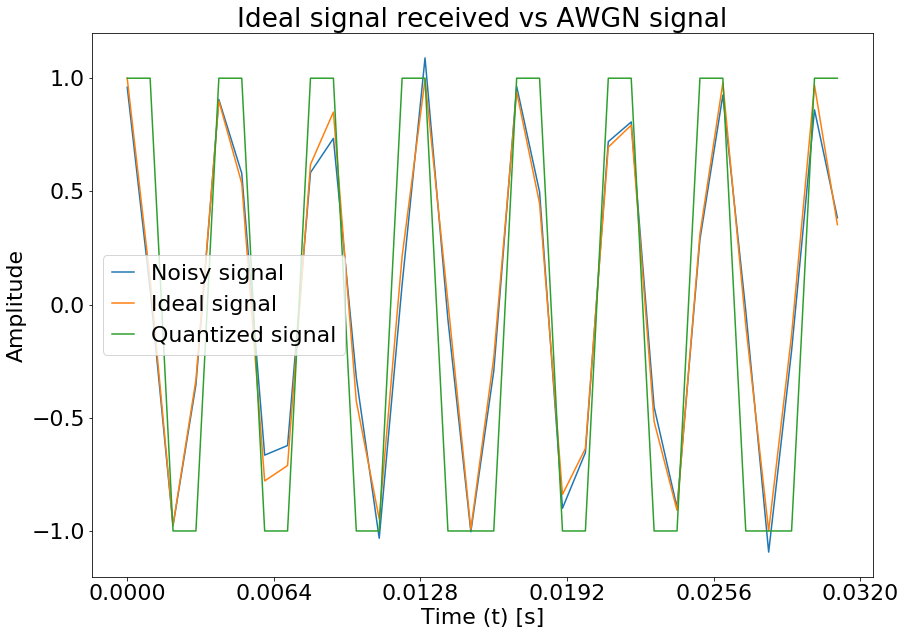

Mean Square error of quantizers is 0.1716 for linear


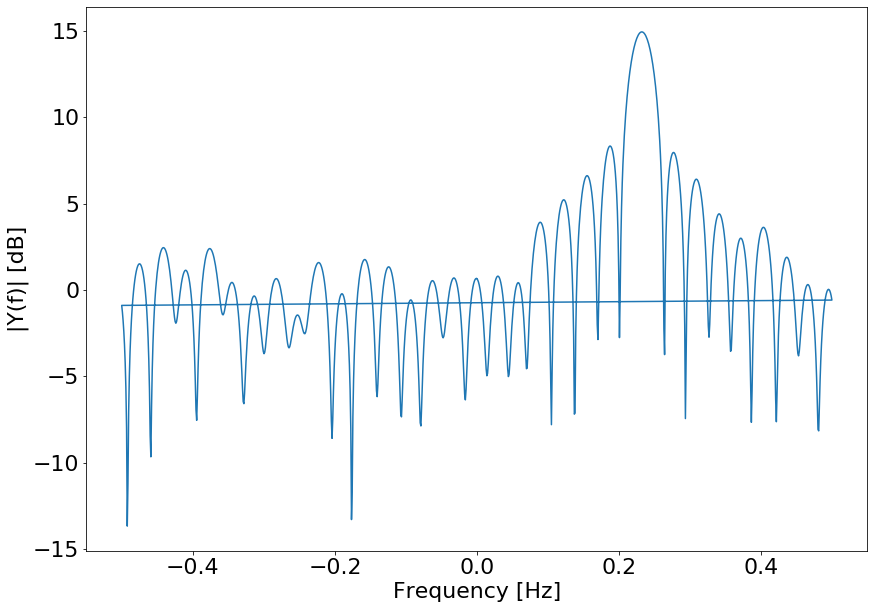

Periodogram peak frequency is 0.2317


20.271575181789416

In [0]:
# generate some ideal data
t = np.arange(0, n)/fs
x, _ = data_generator(min_fc=fc, max_fc=fc, phase_offset=0, amplitude=amplitude, n=n, fs=fs)

# add noise
x_rec, std = generate_noise(x, SNR)
# print(f"snr ={10**(calc_snr(x, x_rec)/10.0)}, also A^2/2o^2 = {amplitude**2/(2*std**2)}")

# quantize values
linear_x, _ = general_quantizer(x_rec, bits=bits, maximum=amplitude, minimum=-amplitude)

# plot for comparison
plt.plot(t, x_rec.real, t, x.real, t, linear_x.real)
plt.title("Ideal signal received vs AWGN signal")
plt.xticks(np.arange(0, tend+1e-8, step=0.2*tend))
plt.xlabel("Time (t) [s]")
plt.ylabel("Amplitude")
plt.legend(["Noisy signal", "Ideal signal", "Quantized signal"], loc="best")
plt.show()
print(f"Mean Square error of quantizers is {mean_squared_error(np.absolute(x), np.absolute(linear_x)):.4f} for linear")

plot_spectrum(x, x_rec)


### Evaluate Estimators

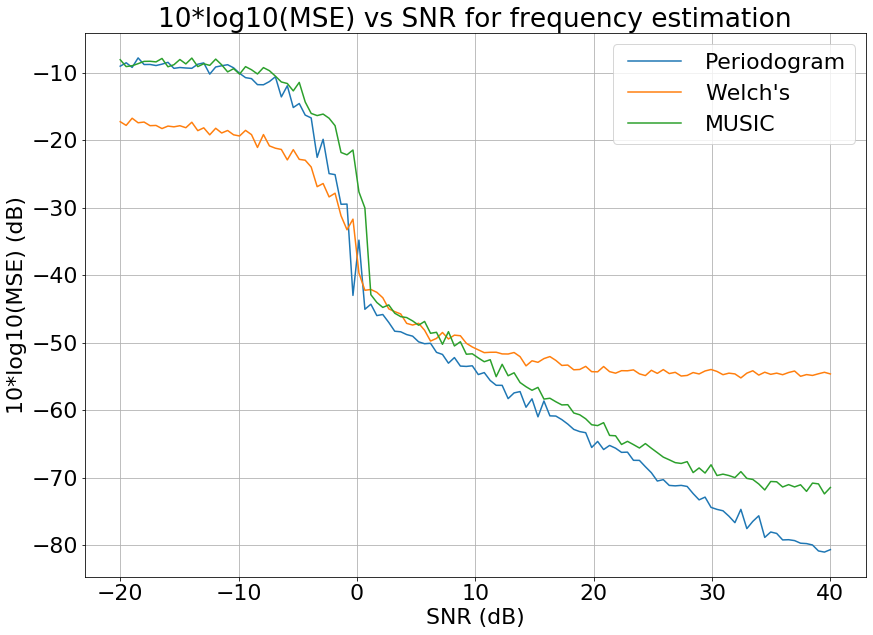

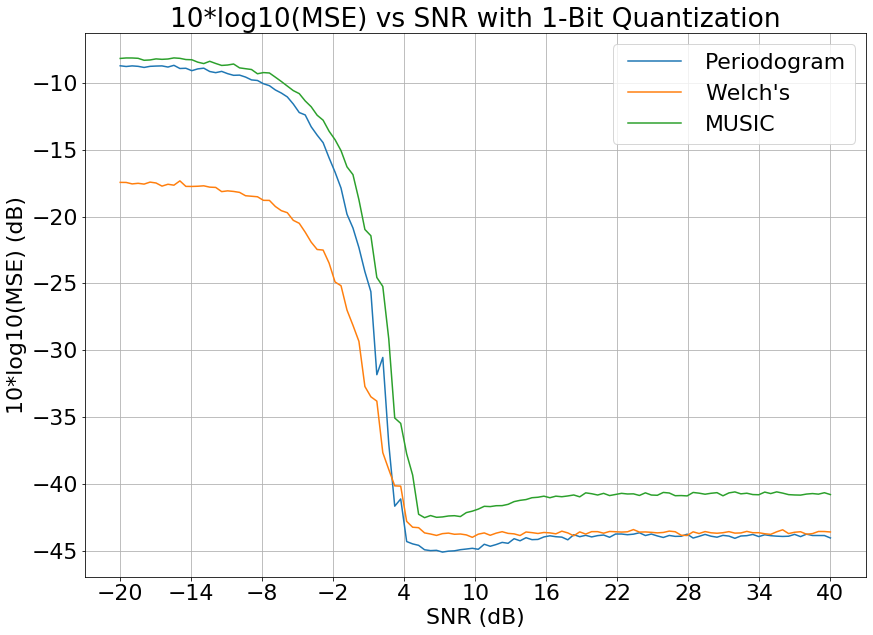

In [0]:
"""
First attempts at creating a script which can be used to compare how various estimators work
at measuring carrier frequency offset (and possible amplitude and phase).
"""
plt.rcParams.update({'legend.handlelength': 3})
plt.rcParams.update({'legend.numpoints': 3})

recalc = False
saver = True

nset = [16]

for ni in nset:
    msepath = "drive/My Drive/Colab Notebooks_UT/CFO/MSES/"+str(ni)+"-point/"
    classic_mse = msepath + "classic.pickle"

    estimators = [Periodogram_estimator, Welchs_Rect_Periodogram, Music_estimator] #, WPA_estimator_1, WPA_estimator_2, WPA_estimator_3, WPA_estimator_4]
    names = ["Periodogram", "Welch's", "MUSIC"] #, "Weighted Phase Averager", "Unweighted Phase Averager", "Weighted Linear", "Unweighted Linear"]
    classic_names = names

    x, _ = data_generator(min_fc=fc, max_fc=fc, amplitude=amplitude, n=ni, fs=fs)

    if recalc is True:
        (snrs, mses) = plot_over_snr(x, -20, 40, fs=fs, min_fc=min_fc, max_fc=max_fc, estimators=estimators, names=names,phase=True, monte_carlos=100)
        (quant_snrs, quant_mses) = plot_over_snr(x, -20, 40, fs=fs, min_fc=min_fc, max_fc=max_fc, estimators=estimators, names=names, phase=True, quantizer=linear_quantizer, bits=bits, monte_carlos=3000)

        print(f"Estimations ={WPA_estimator_1(x_rec)}, {WPA_estimator_2(x_rec)}, {WPA_estimator_3(x_rec)}, {WPA_estimator_4(x_rec)} ")

        if saver is True:
            filen = open(classic_mse, "wb")
            pickle.dump([(snrs, mses), (quant_snrs, quant_mses)], filen )
            filen.close()
        
    else:
        filen = open( classic_mse, "rb")
        (snrs, mses), (quant_snrs, quant_mses) = pickle.load(filen)
        filen.close()
        for i in range(len(mses)):
            plt.plot(snrs, mses[i])

        plt.legend(names)
        plt.title(f"10*log10(MSE) vs SNR for frequency estimation")
        plt.xlabel("SNR (dB)")
        plt.ylabel("10*log10(MSE) (dB)")
        plt.grid()
        plt.show()

        for i in range(len(quant_mses)):
            plt.plot(snrs, quant_mses[i])
            
        plt.title(f"10*log10(MSE) vs SNR with 1-Bit Quantization")
        plt.xlabel("SNR (dB)")
        plt.ylabel("10*log10(MSE) (dB)")
        plt.legend(names)
        plt.grid()
        plt.xticks(np.arange(-20, 40+1.0e-5, step=0.1*(40+20)))
        plt.show()


### Three Level Comp

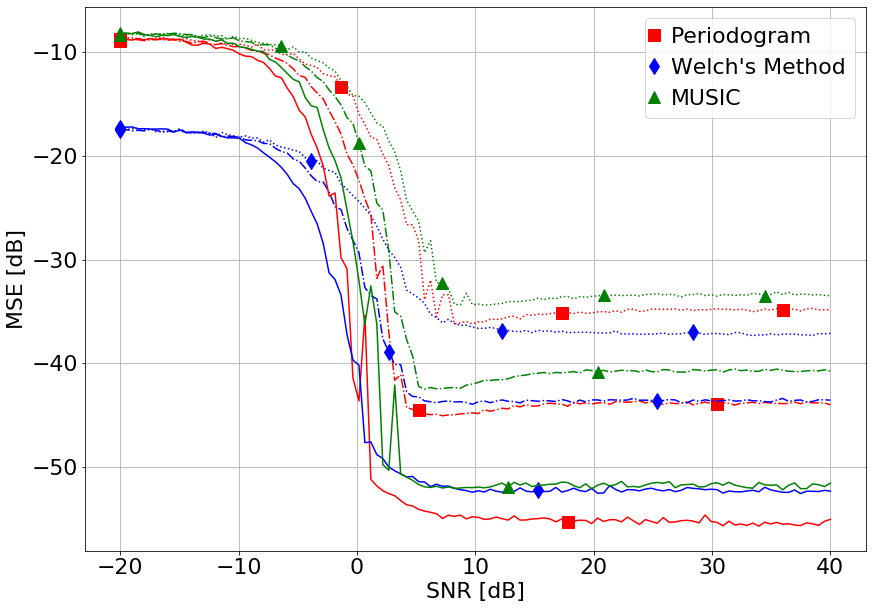

In [0]:
# Plot 8, 16, 32 points on the same graph
plt.rcParams.update({'legend.handlelength': 0})
plt.rcParams.update({'legend.numpoints': 1})

default_nset = [8, 16, 32]
default_markerset = [['rs:', 'bd:', 'g^:',], ['rs-.', 'bd-.', 'g^-.', ], ['rs-', 'bd-', 'g^-']]

def nset_plot(str_estimator, title, name=None, nset=default_nset, markerset=default_markerset, classics=False):
    markersize = 12
    for index, ni in enumerate(nset):
        markever = 150//(4-index)
        msepath = "drive/My Drive/Colab Notebooks_UT/CFO/MSES/"+str(ni)+"-point/"

        if str_estimator is None or isinstance(str_estimator, str):
            classic_mse = msepath + "classic.pickle"
            filen = open( classic_mse, "rb")
            (snrs, mses), (quant_snrs, quant_mses) = pickle.load(filen)
            filen.close()

            if str_estimator is None:
                for i in range(len(quant_mses)):
                    plt.plot(snrs, quant_mses[i], markerset[index][i], markevery=markever, markersize=markersize)
                    markever -= 5
                    plt.legend(["Periodogram", "Welch's Method", "MUSIC"])
            else:
                for i in range(3):
                    plt.plot(snrs, quant_mses[i], markerset[index][i], markevery=markever, markersize=markersize)
                    markever -= 5

                filen = open( msepath + str_estimator, "rb")
                (snrs, mses), (quant_snrs, quant_mses) = pickle.load(filen)
                filen.close()
                plt.plot(quant_snrs, quant_mses.reshape(120), markerset[index][2], markevery=markever, markersize=markersize)
                plt.legend(["Periodogram", "Welch's Method"] + [name])

        else:
            for i, estimator in enumerate(str_estimator):
                filen = open( msepath + estimator, "rb")
                (snrs, mses), (quant_snrs, quant_mses) = pickle.load(filen)
                filen.close()
                plt.plot(quant_snrs, quant_mses.reshape(120), markerset[index][i], markevery=markever-2*i, markersize=markersize)

            plt.legend(name)

            if classics==True:
                classic_mse = msepath + "classic.pickle"
                filen = open( classic_mse, "rb")
                (snrs, mses), (quant_snrs, quant_mses) = pickle.load(filen)
                filen.close()
                print("Using classics, make sure you have",i+4, "markers")

                for j in range(3):
                    plt.plot(snrs, quant_mses[j], markerset[index][i+j+1], markevery=markever, markersize=markersize)
                    markever -= 5


                plt.legend(name+["Periodogram", "Welch's Method", "MUSIC"])

    # plt.title(title)
    plt.xlabel("SNR [dB]")
    plt.ylabel("MSE [dB]")
    plt.grid()
    plt.show()


nset_plot(None, "Classical Frequency Estimation Techniques with 1-bit Quantization")

### Timing

In [0]:
num_tests = 100

datam = np.array([])
for i in range(num_tests):
    datam = np.append(datam, x_rec)
datam = datam.reshape(num_tests, n)

In [0]:
def Periodogram_estimator_Matrix(data):
    """
    Implements the MLE error for frequency estimation, which is the periodogram method
    :param data: input time domain data
    :param fs: sampling frequency
    :return: highest frequency peak of the periodogram
    """
    first_d = data.shape[0]
    length = 2**12
    dfft = np.absolute(fft(np.complex128(data), n=length), dtype=np.float128)
    frequencies = np.fft.fftfreq(length)
    interp = False
    mle_freqs = np.zeros((first_d, 1))

    # interpolate from top 3 frequencies

    for k in range(first_d):
        idx = np.argmax(dfft[i, :])
    
        if interp is True:
            if idx == length-1:
                mle_freq = frequencies[idx]

            else:
                indices = [idx-1, idx, idx+1]
                freqs = frequencies[indices].astype(np.float64)
                values = np.abs(dfft[indices]).astype(np.float64)

                mle_freq[i] = interpolation(freqs, values)
        else:
            mle_freqs[i] = frequencies[idx]
        
    return mle_freqs

def Welchs_Rect_Periodogram_Matrix(data):
    """
    Implements the MLE error for frequency estimation, which is the periodogram method
    :param data: input time domain data
    :param fs: sampling frequency
    :return: highest frequency peak of the periodogram
    """
    first_d = data.shape[0]
    length = 2**12

    frequencies, dfft = scipy.signal.welch(data, nfft=length, window='boxcar', nperseg=data.shape[1]//2)
    mle_freqs = np.zeros((first_d, 1))
    interp = False

    # interpolate from top 3 frequencies
    for i in range(first_d):
        idx = np.argmax(np.abs(dfft[i, :]))
        
        if interp is True:
            if idx == length-1:
                mle_freqs[i] = frequencies[idx]

            else:
                indices = [idx-1, idx, idx+1]
                freqs = frequencies[indices].astype(np.float64)
                values = np.abs(dfft[i, indices]).astype(np.float64)

                mle_freqs[i] = interpolation(freqs, values)
        else:
            mle_freqs[i] = mle_freqs[i] = frequencies[idx]
        
    return mle_freqs

In [0]:
%timeit -n 50 Periodogram_estimator_Matrix(datam)

50 loops, best of 3: 33 ms per loop


In [0]:
%timeit -n 50 Welchs_Rect_Periodogram_Matrix(datam)

/usr/local/lib/python3.6/dist-packages/scipy/signal/spectral.py:1815: UserWarning: Input data is complex, switching to return_onesided=False
  warnings.warn('Input data is complex, switching to '


50 loops, best of 3: 37.8 ms per loop


In [0]:
%timeit -n 50 [Music_estimator(x_rec) for i in range(num_tests)] 

50 loops, best of 3: 466 ms per loop


In [0]:
main_path = 'drive/My Drive/Colab Notebooks_UT/CFO/Models/'
mod1 = 'm-L1024_L256_L64_snr_0-10.h5py'
mod2 = 'C8_C16_C32_C64_C128_C256_L128_L64_snr_0-10.h5py'
mod3 = 'LSTM16_LSTM32_LSTM64_L128_L64_snr_0-10.h5py'
mod4 = 'C8_R16_R32_R64_R128_R256_L128_L64_snr_0-10.h5py'
model_name = [mod1, mod2, mod4]

for i in range(4):
    model_path = main_path + str(n)+'-point/' + model_name[i]

    model = keras.models.load_model(model_path)
    x_rec2 = convert_complex_to_real(x_rec).reshape(1, n, 2)

    datam = np.array([])
    for i in range(num_tests):
        datam = np.append(datam, x_rec2)
    datam = datam.reshape(num_tests, n, 2)

    %timeit -n 50 model.predict(datam)

    del model

Text(0.5, 1.0, 'Estimation Time for 100 Signals vs Number of Pilot Symbols')

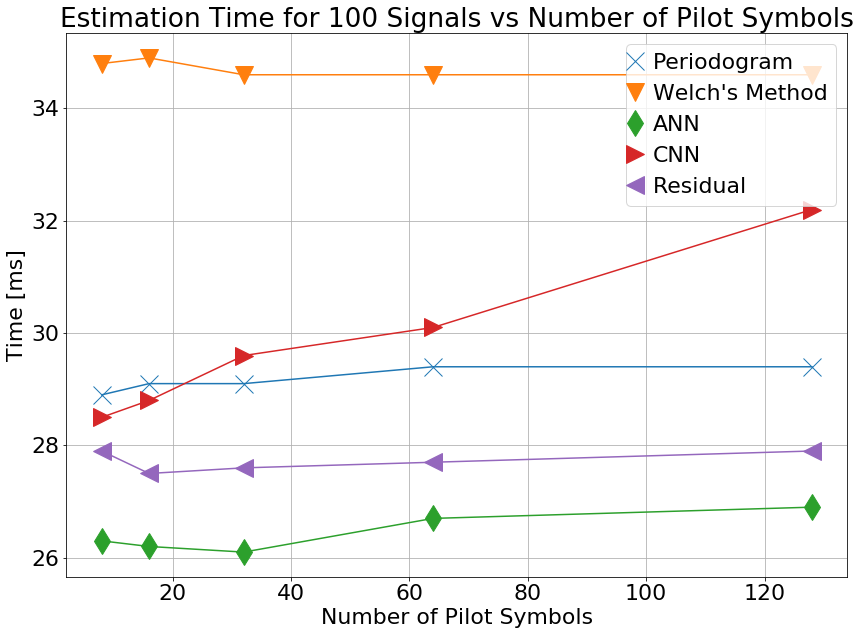

In [0]:
# make plot of timing points
DL = True
zoom = True

points = [8, 16, 32, 64, 128]
pervals = [28.9, 29.1, 29.1, 29.4, 29.4]
welchs = [34.8, 34.9, 34.6, 34.6, 34.6]
musvals = [160, 272, 452, 926, 4040]

annvals = [26.3, 26.2, 26.1, 26.7, 26.9]
cnnvals = [28.5, 28.8, 29.6, 30.1, 32.2]
rnnvals = [62.9, 93.3, 154, 273, 515]
resvals = [27.9, 27.5, 27.6, 27.7, 27.9]

leg = []

plt.plot(points, pervals, 'x-', markersize=18)
plt.plot(points, welchs, 'v-', markersize=18)
leg.append("Periodogram")
leg.append("Welch's Method")
if zoom == False:
    plt.plot(points, musvals, 'o-', markersize=18)
    leg.append("MUSIC")


if DL == True:
    plt.plot(points, annvals, 'd-', markersize=18)
    leg.append("ANN")
    plt.plot(points, cnnvals, '>-', markersize=18)
    leg.append("CNN")
    if zoom == False:
        plt.plot(points, rnnvals, 's-', markersize=18)
        leg.append("RNN")
    plt.plot(points, resvals, '<-', markersize=18)
    leg.append("Residual")

plt.legend(leg)
plt.xlabel("Number of Pilot Symbols")
plt.ylabel("Time [ms]")
plt.grid()
plt.title("Estimation Time for 100 Signals vs Number of Pilot Symbols")

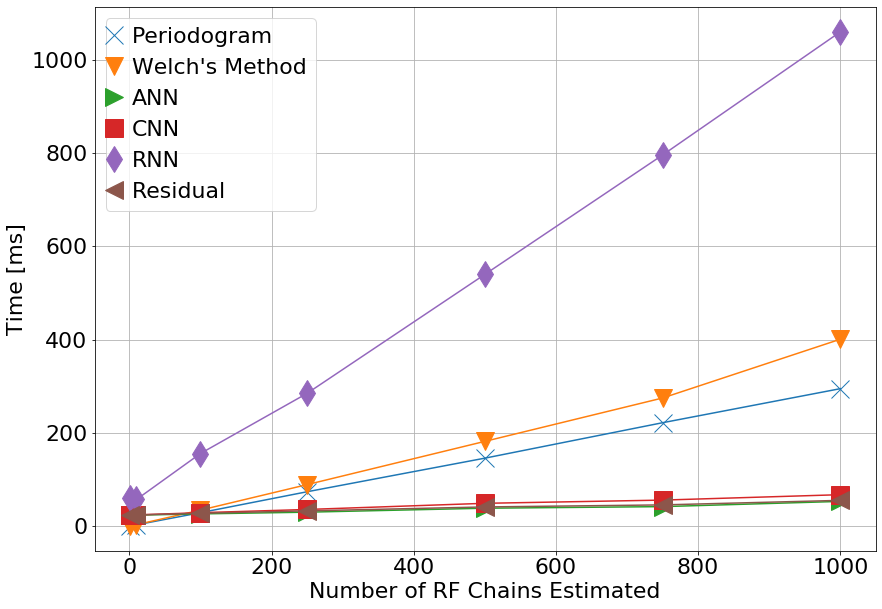

In [0]:
DL = True
zoom = True
# plot of timing vs number of estimations
points = [1, 10, 100, 250, 500, 750, 1000]
pervals = [0.359, 3.07, 29.1, 74, 146, 222, 295]
welchs = [0.427, 3.38, 34.6, 89.3, 182, 275, 401]
musvals = [3.8, 37.5, 376, 876, 1780, 2630, 4740]

annvals = [23.7, 23.9, 26.5, 30.2, 38.7, 42.1, 53.3]
cnnvals = [24.6, 24.4, 29.1, 36, 49.2, 56.1, 67.7]
rnnvals = [60, 57.4, 156, 285, 540, 796, 1060]
resvals = [24.6, 24.2, 27.9, 33, 41.4, 45.8, 55.5]

names = []
plt.plot(points, pervals, 'x-', markersize=18)
names.append("Periodogram")
plt.plot(points, welchs, 'v-', markersize=18)
names.append("Welch's Method")
if zoom==False:
    plt.plot(points, musvals, 'o-', markersize=18)
    names.append("MUSIC")
if DL == True:
    plt.plot(points, annvals, '>-', markersize=18)
    names.append("ANN")
    plt.plot(points, cnnvals, 's-', markersize=18)
    names.append("CNN")
    plt.plot(points, rnnvals, 'd-', markersize=18)
    names.append("RNN")
    plt.plot(points, resvals, '<-', markersize=18)
    names.append("Residual")

plt.legend(names)

plt.xlabel("Number of RF Chains Estimated")
plt.ylabel("Time [ms]")
plt.grid()
# plt.title("Estimation Time vs Number of Signals for N=32 Pilots")

# Deep Learning

In [0]:
import tensorflow.keras as keras
from tensorflow.keras import backend as K

print(tf.__version__)

K.set_floatx('float64')
K.set_epsilon(1e-12)

2.1.0


In [0]:
size = 800000
min_snr = 0
max_snr=10

In [0]:
dataset, freqs = build_dataset(min_fc=1, max_fc=1000, size=size, min_digital_freq=0.01, max_digital_freq=0.4, n=n, min_snr=min_snr, max_snr=max_snr, split_real_imag=True, quantizer=True)
dataset = dataset.reshape(size, n, 2).astype(np.float64)
print(dataset.shape)
validation_size = 0.15             # 15% test size
x_train, x_test, y_train, y_test = model_selection.train_test_split(dataset, freqs, test_size= validation_size, random_state = seed)

(180000, 8, 2)


In [0]:
x_train.shape

(153000, 8, 2)

In [0]:
train = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(32).shuffle(1000)
test = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32).shuffle(1000)
train = train.prefetch(tf.data.experimental.AUTOTUNE)
test = test.prefetch(tf.data.experimental.AUTOTUNE)

In [0]:
class resblock(keras.layers.Layer):
    def __init__(self, n_layers, n_neurons, **kwargs):
        super().__init__(**kwargs)
        self.hidden = [keras.layers.Dense(n_neurons,
                                          activation='relu',
                                          kernel_initializer='he_normal')
                       for _ in range(n_layers)]
    @tf.function    
    def call(self, inputs):
        z = inputs
        for layer in self.hidden:
            z = layer(z)
        return inputs + z
    
    def get_config(self):
        base_config = super().get_config()
        return {**base_config}
    
class Residual(keras.layers.Layer):
    def __init__(self, num_channels, use_1x1=False, strides=1, **kwargs):
        super(Residual, self).__init__(**kwargs)
        self.conv1 = keras.layers.Conv1D(num_channels, strides=strides, kernel_size=3,
                                         padding='SAME', activation='relu')
        self.conv2 = keras.layers.Conv1D(num_channels, strides=strides, kernel_size=3,
                                         padding='SAME', activation='relu')

        if use_1x1:
            self.conv3 = keras.layers.Conv1D(num_channels, strides=strides, kernel_size=1,
                                              activation='relu')
        else:
            self.conv3 = None

        def forward(self, X):
            Y = self.conv1(X)
            Y = self.conv2(Y)
            if self.conv3:
                X = self.conv3(X)
            return tf.nn.relu(Y + X)

        def get_config(self):
            base_config = super().get_config()
            return {**base_config}

In [0]:
default_Dense = partial(keras.layers.Dense, activation='relu', kernel_initializer='he_normal')
default_Conv = partial(keras.layers.Conv1D, kernel_size=3, strides = 1, padding='SAME', activation='relu')

net1 = keras.models.Sequential([
                keras.layers.InputLayer((ni, 2)),
                keras.layers.Flatten(),
                default_Dense(1024),
                default_Dense(256),
                default_Dense(64),
                keras.layers.Dense(1)
            ])

net2 = keras.models.Sequential([
                keras.layers.InputLayer((ni, 2)),
                default_Conv(8),
                default_Conv(16),
                default_Conv(32),
                default_Conv(64),
                default_Conv(128),
                default_Conv(256),
                keras.layers.Flatten(),
                default_Dense(128),
                default_Dense(64),
                keras.layers.Dense(1),
            ])

net3 = keras.models.Sequential([
                keras.layers.InputLayer((ni, 2)),
                keras.layers.LSTM(16, return_sequences=True),
                keras.layers.LSTM(32, return_sequences=True),
                keras.layers.LSTM(64),
                keras.layers.Flatten(),
                default_Dense(128),
                default_Dense(64),
                keras.layers.Dense(1),
            ])

net4 = keras.models.Sequential([
                keras.layers.InputLayer((ni, 2)),
                default_Conv(8),
                Residual(16, use_1x1=True),
                Residual(32, use_1x1=True),
                Residual(64, use_1x1=True),
                Residual(128, use_1x1=True),
                Residual(256, use_1x1=True),
                keras.layers.Flatten(),
                default_Dense(128),
                default_Dense(64),
                keras.layers.Dense(1),
            ])

networks = [net1, net2, net3, net4]

DL_names = ['_m-L1024_L256_L64_snr_', '_C8_C16_C32_C64_C128_C256_L128_L64_snr_',
         '_LSTM16_LSTM32_LSTM64_L128_L64_snr_', '_C8_R16_R32_R64_R128_R256_L128_L64_snr_']

## Automated Model Training

Starting n=16
(500000, 16, 2)
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 32)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 1024)              33792     
_________________________________________________________________
dense_14 (Dense)             (None, 256)               262400    
_________________________________________________________________
dense_15 (Dense)             (None, 64)                16448     
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 65        
Total params: 312,705
Trainable params: 312,705
Non-trainable params: 0
_________________________________________________________________
Train for 13282 steps, validate for 2344 steps
Epoch 1/1000
13282/13282 - 49s - loss

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:309: ComplexWarning: Casting complex values to real discards the imaginary part


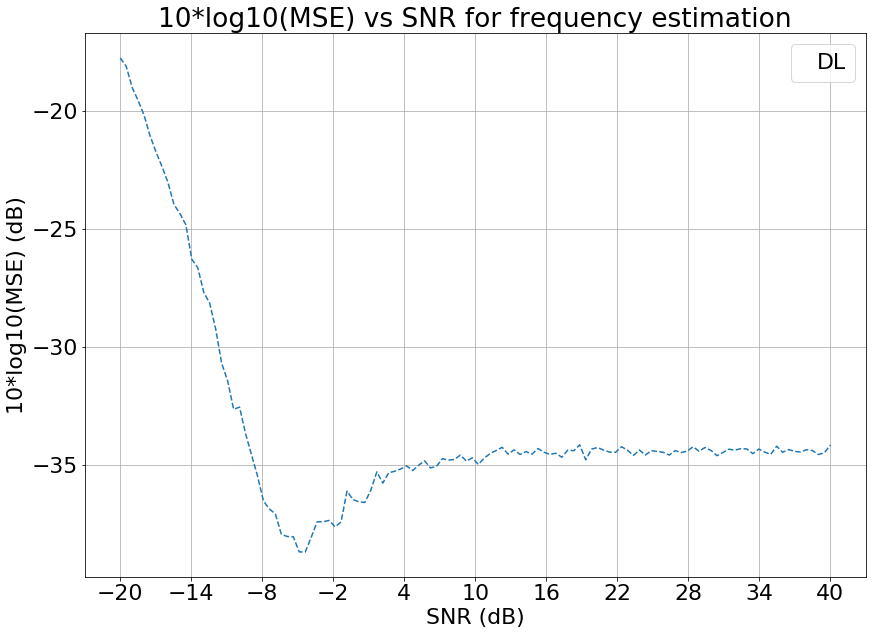

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:309: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:312: ComplexWarning: Casting complex values to real discards the imaginary part


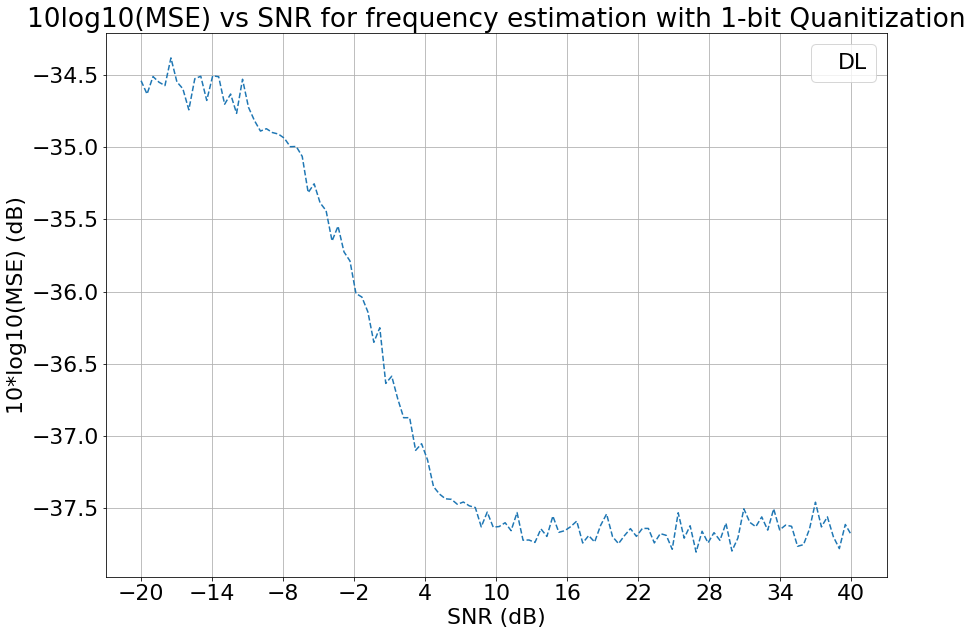

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 16, 16)            1216      
_________________________________________________________________
lstm_7 (LSTM)                (None, 16, 32)            6272      
_________________________________________________________________
lstm_8 (LSTM)                (None, 64)                24832     
_________________________________________________________________
flatten_10 (Flatten)         (None, 64)                0         
_________________________________________________________________
dense_33 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_34 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_35 (Dense)             (None, 1)               

In [0]:
## Automated Model Training for each n
nset = [16, 32]

size = 500000
min_snr = 0
max_snr= 10
quantizing = True

default_Dense = partial(keras.layers.Dense, activation='relu', kernel_initializer='he_normal')
default_Conv = partial(keras.layers.Conv1D, kernel_size=3, strides = 1, padding='SAME', activation='relu')

early_stopping = keras.callbacks.EarlyStopping(patience=12, restore_best_weights = True)
lr_reduc = tf.keras.callbacks.ReduceLROnPlateau(patience=6, factor=0.5, verbose=0, min_lr=4e-6)
callbacks = [early_stopping, lr_reduc]
# callbacks = []

net_sel = 1


def model_est(data):
    data = convert_complex_to_real(data)
    model1 = keras.models.load_model(model_name1)
    y = model1.predict(data.reshape(1, n, 2))
    del model1
    return y


def multi_est_model(data):
    data = np.array(data)
    # model1 = keras.models.load_model(model_name1)
    datam = np.array([])
    for i in range(len(data)):
        datam = np.append(datam, convert_complex_to_real(data[i]))
    results = model.predict(datam.reshape(len(data), ni, 2))
    # del model1
    return results

    
for ni in nset:
    # Data generation
    print(f"Starting n={ni}")
    x, _ = data_generator(min_fc=min_fc, max_fc=max_fc, phase_offset=0, amplitude=amplitude, n=ni, fs=fs)

    dataset, freqs = build_dataset(min_fc=fs/5.0, max_fc=fs/4.0, size=size, fs=fs, phase_offset=True, n=ni, min_snr=min_snr, max_snr=max_snr, split_real_imag=True, quantizer=quantizing)
    dataset = dataset.reshape(size, ni, 2).astype(np.float64)
    print(dataset.shape)
    validation_size = 0.15             # 15% test size
    x_train, x_test, y_train, y_test = model_selection.train_test_split(dataset, freqs, test_size=validation_size, random_state=seed)
    train = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(32).shuffle(100000)
    test = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32).shuffle(100000)
    train = train.prefetch(tf.data.experimental.AUTOTUNE)
    test = test.prefetch(tf.data.experimental.AUTOTUNE)

    for nsel in [0,2,3]:

        net1 = keras.models.Sequential([
                keras.layers.InputLayer((ni, 2)),
                keras.layers.Flatten(),
                default_Dense(1024),
                default_Dense(256),
                default_Dense(64),
                keras.layers.Dense(1)
            ])

        net2 = keras.models.Sequential([
                        keras.layers.InputLayer((ni, 2)),
                        default_Conv(8),
                        default_Conv(16),
                        default_Conv(32),
                        default_Conv(64),
                        default_Conv(128),
                        default_Conv(256),
                        keras.layers.Flatten(),
                        default_Dense(128),
                        default_Dense(64),
                        keras.layers.Dense(1),
                    ])

        net3 = keras.models.Sequential([
                        keras.layers.InputLayer((ni, 2)),
                        keras.layers.LSTM(16, return_sequences=True),
                        keras.layers.LSTM(32, return_sequences=True),
                        keras.layers.LSTM(64),
                        keras.layers.Flatten(),
                        default_Dense(128),
                        default_Dense(64),
                        keras.layers.Dense(1),
                    ])

        net4 = keras.models.Sequential([
                        keras.layers.InputLayer((ni, 2)),
                        default_Conv(8),
                        Residual(16, use_1x1=True),
                        Residual(32, use_1x1=True),
                        Residual(64, use_1x1=True),
                        Residual(128, use_1x1=True),
                        Residual(256, use_1x1=True),
                        keras.layers.Flatten(),
                        default_Dense(128),
                        default_Dense(64),
                        keras.layers.Dense(1),
                    ])

        networks = [net1, net2, net3, net4]

        DL_names = ['_m-L1024_L256_L64_snr_', '_C8_C16_C32_C64_C128_C256_L128_L64_snr_',
                '_LSTM16_LSTM32_LSTM64_L128_L64_snr_', '_C8_R16_R32_R64_R128_R256_L128_L64_snr_']

        
        # Model definition

        if quantizing:
            name1 = 'BIG_PT_Q' + DL_names[nsel] + str(min_snr) + '-' + str(max_snr) + '.h5py'
        else:
            name1 = 'PT' + DL_names[nsel] + str(min_snr) + '-' + str(max_snr) + '.h5py'

        if tpu:
            with strategy.scope(): # this line is all that is needed to run on TPU (or multi-GPU, ...)
                model = networks[nsel]


                optimizer = tf.keras.optimizers.Adam()
                model.compile(loss='mse', optimizer=optimizer, metrics=['mae'])
                model.summary()

        else:
            model = networks[nsel]


            optimizer = tf.keras.optimizers.Adam()
            model.compile(loss='mse', optimizer=optimizer, metrics=['mae'])
            model.summary()

        # Model Training
        model.fit(train, validation_data=test, epochs=1000, callbacks=callbacks, verbose=2)
        model.evaluate(test)

        model_path = 'drive/My Drive/Colab Notebooks_UT/CFO/Models/'+str(ni)+"-point/"
        print(model_path)

        model_name1 = model_path + name1
        model.save(model_name1)
        
        msepath = "drive/My Drive/Colab Notebooks_UT/CFO/MSES/"+str(ni)+"-point/"
        DL_path = msepath + name1[:-4] + "pickle"
        # DL_path = 'drive/My Drive/Colab Notebooks_UT/CFO/'+ "n" +str(n)+"-" + name1[:-4] + "pickle"

        (dlsnrs, dlmses) = plot_over_snr_DL(x, -20, 40, fs=fs, min_fc=min_fc, max_fc=max_fc, phase=True, estimators=[multi_est_model], names=["DL"], monte_carlos=200)
        (quant_dlsnrs, quant_dlmses) = plot_over_snr_DL(x, -20, 40, fs=fs, min_fc=min_fc, max_fc=max_fc, estimators=[multi_est_model], names=["DL"], phase=True, quantizer=linear_quantizer, bits=bits, monte_carlos=2000)
        
        filen = open(DL_path, "wb")
        pickle.dump([(dlsnrs, dlmses), (quant_dlsnrs, quant_dlmses)], filen )
        filen.close()
    
    # from google.colab import files
    
    # files.download(DL_path)

## Fix Plot Information

In [0]:
## Rerun the simulation if it was too noisy
n = 16

name1 = 'Q_LSTM16_LSTM32_Res32-3_L128_L64_L32_snr_10-20.h5py'
model_path = 'drive/My Drive/Colab Notebooks_UT/CFO/Models/'+str(n)+'-point/'
model_name = model_path + name1
msepath = 'drive/My Drive/Colab Notebooks_UT/CFO/MSES/'+str(n)+'-point/'
DL_path = msepath + name1[:-4] + "pickle"
model = keras.models.load_model(model_name)

def update_snrs(modelname, n):
    # name1 = 'Q_L64_Res64-4_L128_Res128-3_L256_Res256-2_L64_snr_0-10.h5py'
    model_path = 'drive/My Drive/Colab Notebooks_UT/CFO/Models/'+str(n)+'-point/'
    model_name = model_path + modelname
    msepath = 'drive/My Drive/Colab Notebooks_UT/CFO/MSES/'+str(n)+'-point/'
    DL_path = msepath + modelname[:-4] + "pickle"
    model = keras.models.load_model(model_name)

    def multi_est_model(data):
        data = np.array(data)
        # model1 = keras.models.load_model(model_name1)
        datam = np.array([])
        for i in range(len(data)):
            datam = np.append(datam, convert_complex_to_real(data[i]))
        results = model.predict(datam.reshape(len(data), n, 2))
        # del model1
        return results

    x, _ = data_generator(min_fc=fc, max_fc=fc, amplitude=amplitude, n=n, fs=fs)

    (dlsnrs, dlmses) = plot_over_snr_DL(x, -20, 40, fs=fs, min_fc=min_fc, max_fc=max_fc, estimators=[multi_est_model], phase=True, names=["DL"], monte_carlos=200)
    (quant_dlsnrs, quant_dlmses) = plot_over_snr_DL(x, -20, 40, fs=fs, min_fc=min_fc, max_fc=max_fc, estimators=[multi_est_model], names=["DL"], phase=True, quantizer=linear_quantizer, bits=bits, monte_carlos=2500)

    filen = open(DL_path, "wb")
    pickle.dump([(dlsnrs, dlmses), (quant_dlsnrs, quant_dlmses)], filen )
    filen.close()

# update_snrs(name1, n)


In [0]:
nset = [64, 128]
import os


for ni in nset:
    print(f"Working on n={ni}")
    msepath = 'drive/My Drive/Colab Notebooks_UT/CFO/MSES/' + str(ni) + "-point/"
    m_path = 'drive/My Drive/Colab Notebooks_UT/CFO/Models/'+str(ni)+'-point/'
    estimators = os.listdir(m_path)
    # estimators.remove('classic.pickle')
    for estimator in estimators:
        print(f"Starting {estimator}")
        update_snrs(estimator, ni)

## Total Model Evaluation

### Unquantized Comparison

Graph for n=8


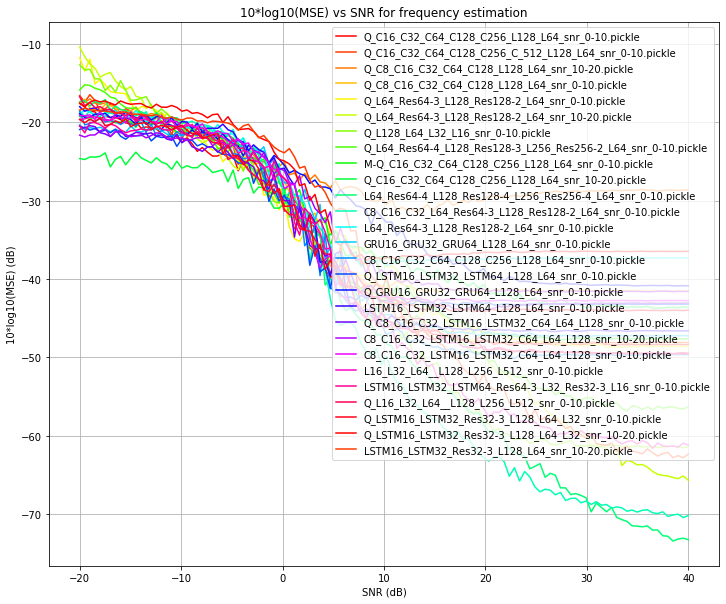

Graph for n=16


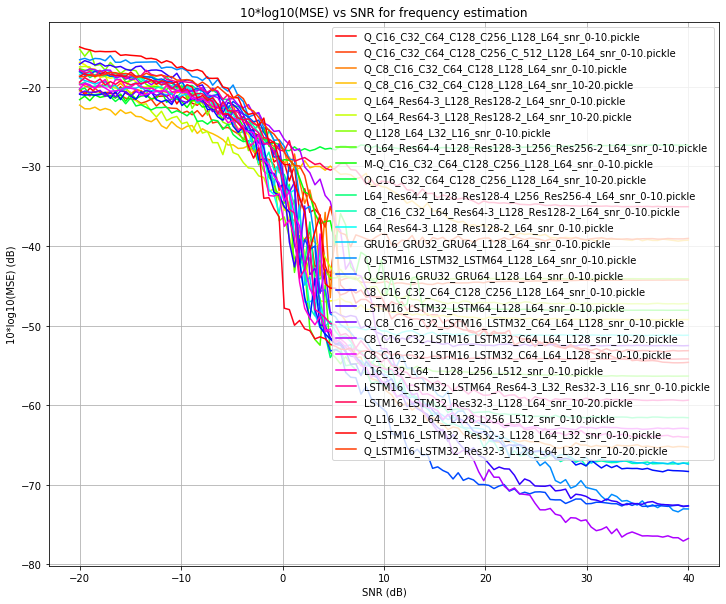

Graph for n=32


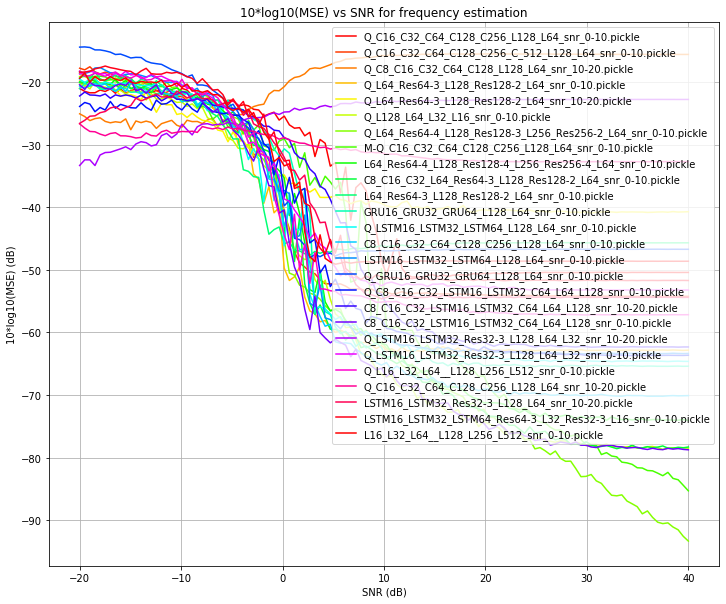

Graph for n=64


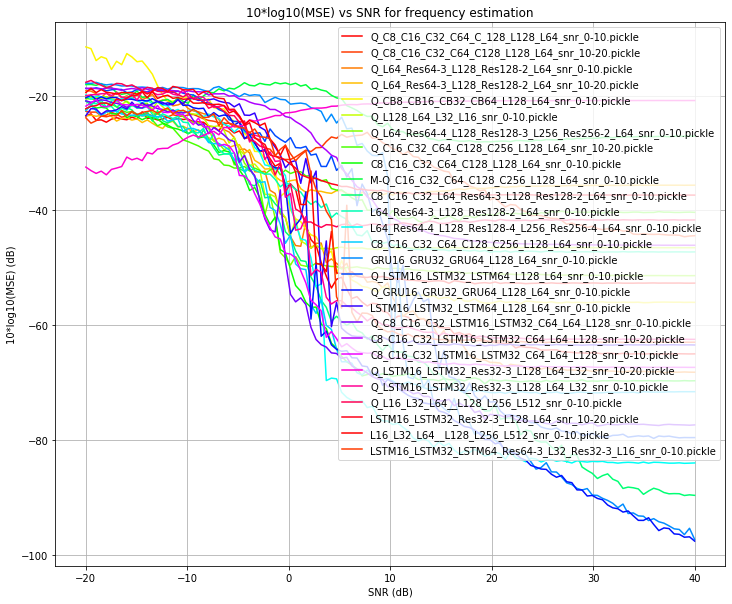

Graph for n=128


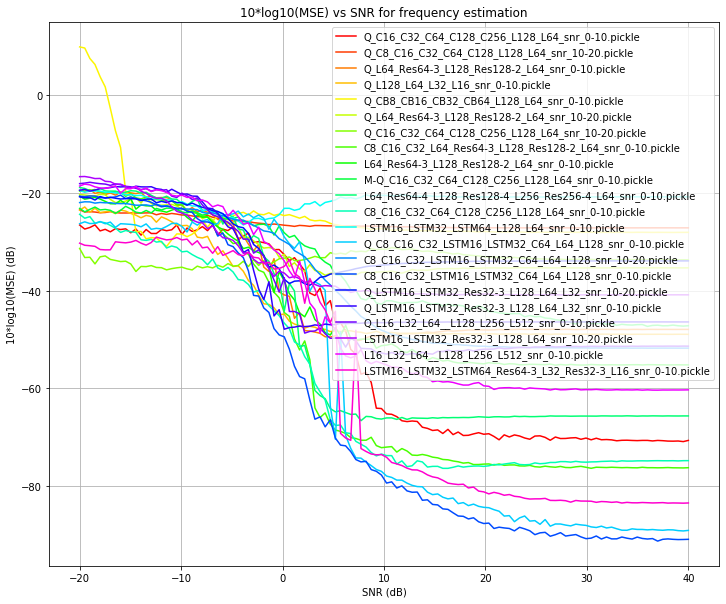

In [0]:
import os

cmap = matplotlib.cm.get_cmap('hsv')

n = np.linspace(0, 1, 25)
colors = cmap(n)

nset = [8, 16, 32, 64, 128]

main_path = 'drive/My Drive/Colab Notebooks_UT/CFO/MSES/'
base_names = ["Periodogram", "Weighted Phase Averager", "Unweighted Phase Averager", "Weighted Linear", "Unweighted Linear"]

## set up plotting
matplotlib.rcParams['figure.figsize'] = [12, 10]

for ni in nset:
    fig, ax = plt.subplots()
    ax.set_prop_cycle(color=colors)

    print(f"Graph for n={ni}")
    msepath = 'drive/My Drive/Colab Notebooks_UT/CFO/MSES/' + str(ni) + "-point/"
    estimators = os.listdir(msepath)
    estimators.remove('classic.pickle')
        
    for estimator in estimators:   
        filen = open(msepath+estimator, "rb")
        (snrs, mses), (quant_snrs, quant_mses) = pickle.load(filen)
        filen.close()
        
        if estimator=='classic.pickle':
            for i in range(len(mses)):
                plt.plot(snrs, mses[i])
        else:
            plt.plot(snrs.reshape(120, 1), mses.reshape(120, 1))
            

    plt.legend(estimators, loc='upper right')
    plt.title(f"10*log10(MSE) vs SNR for frequency estimation")
    plt.xlabel("SNR (dB)")
    plt.ylabel("10*log10(MSE) (dB)")
    plt.grid()
    plt.show()

### Quantized Comparison

Graph for n=8
46


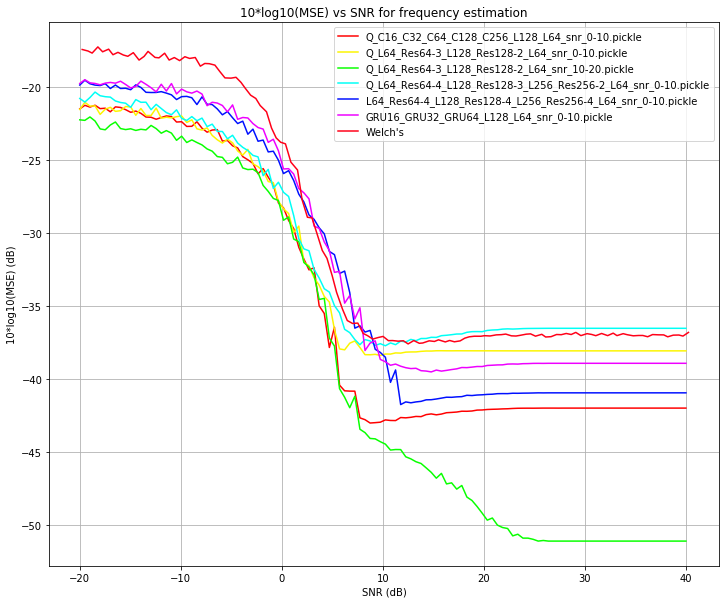

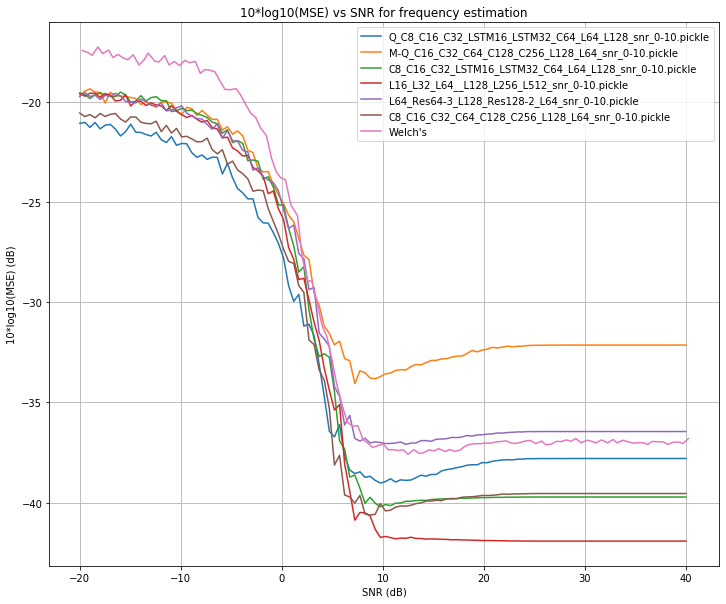

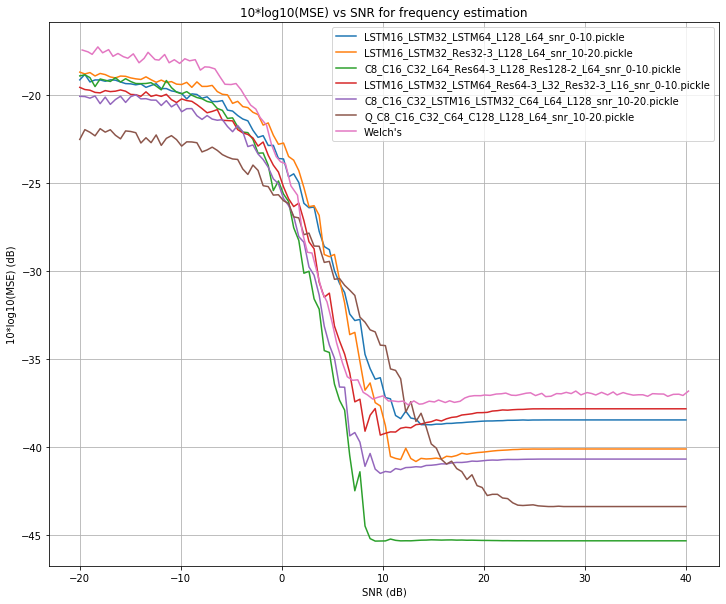

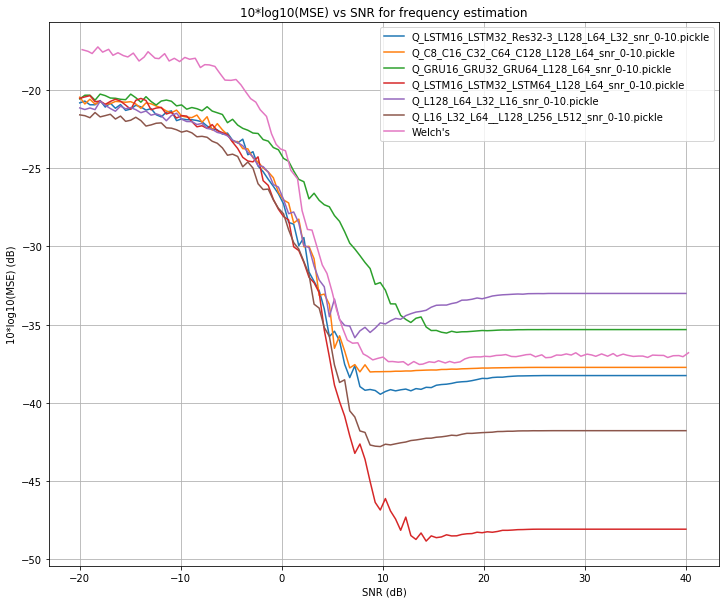

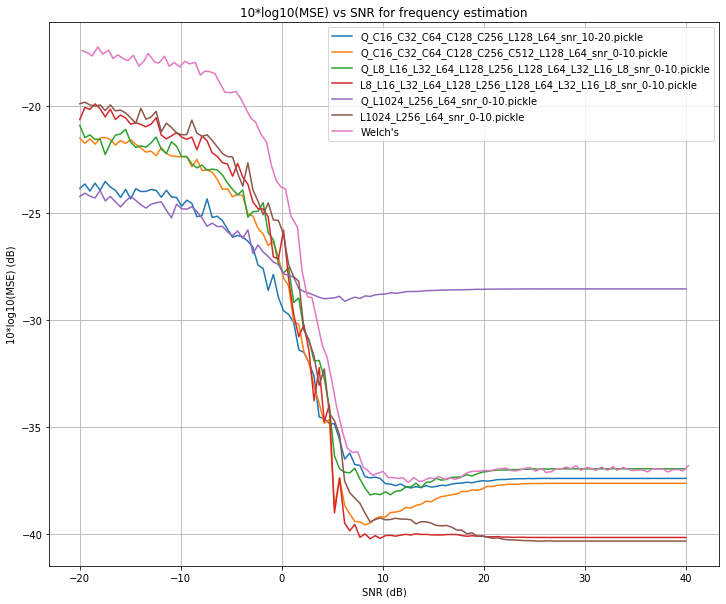

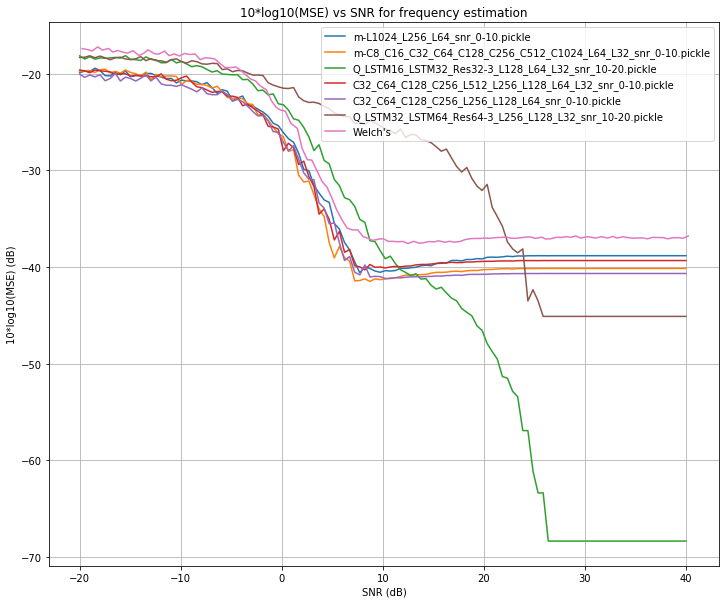

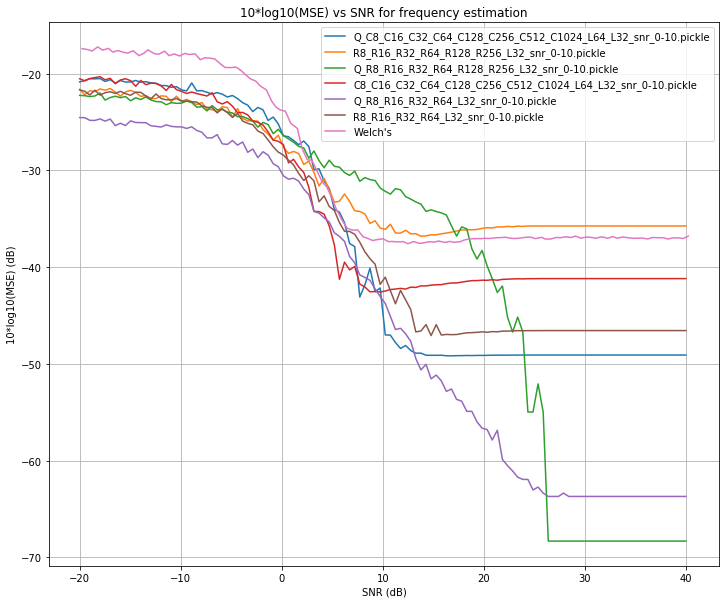

Graph for n=16
46


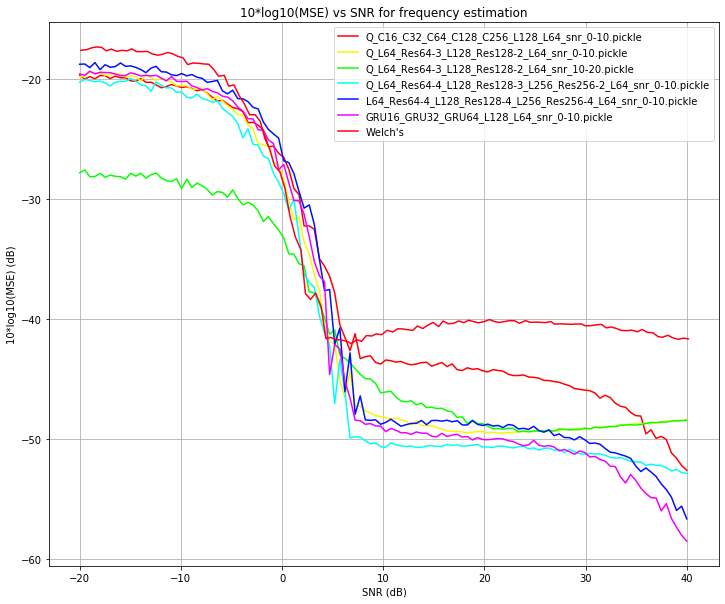

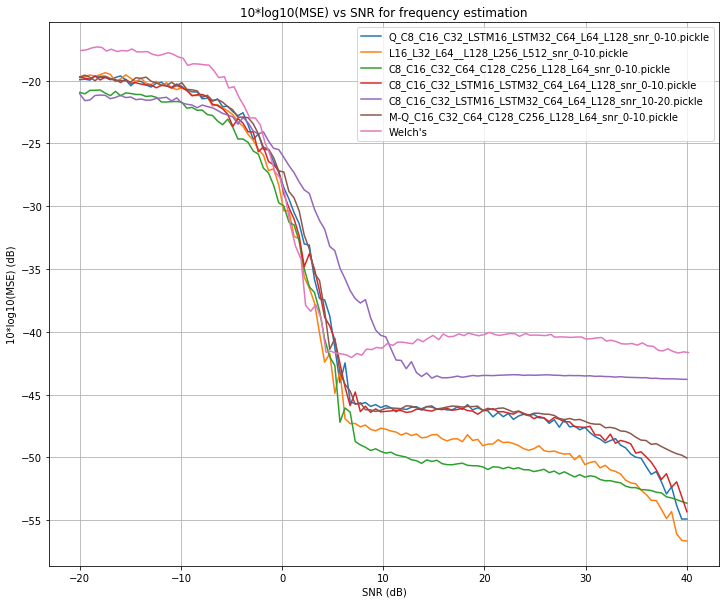

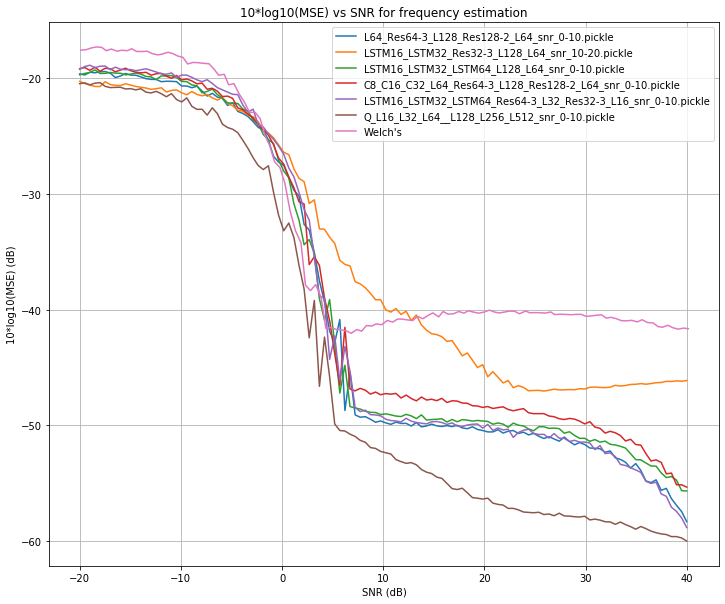

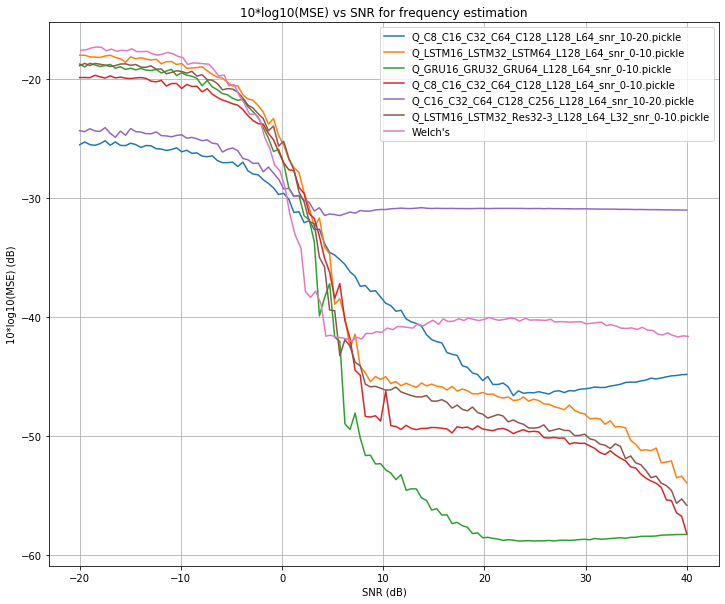

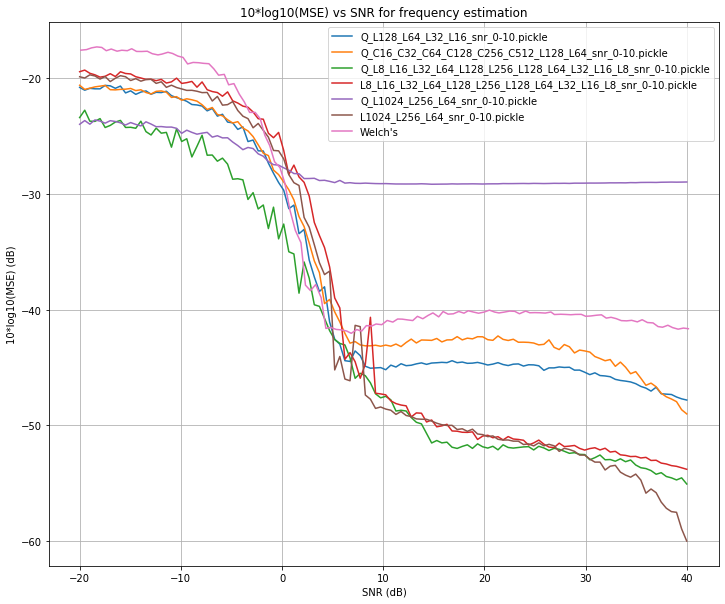

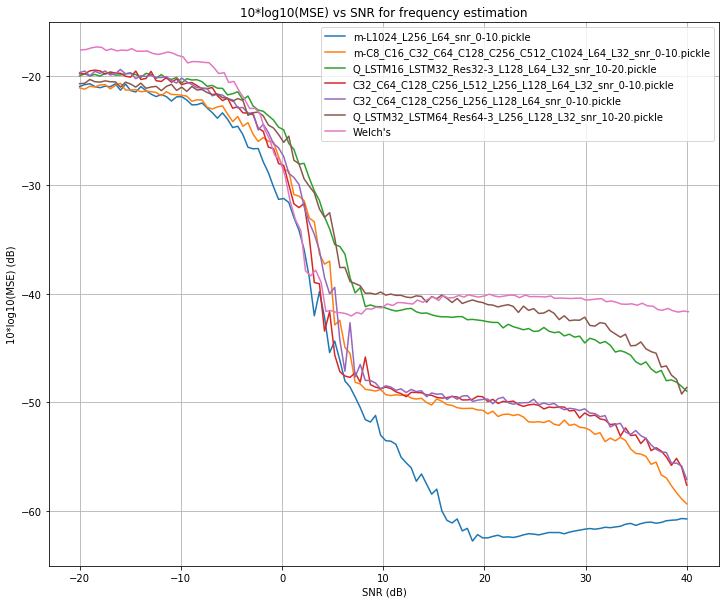

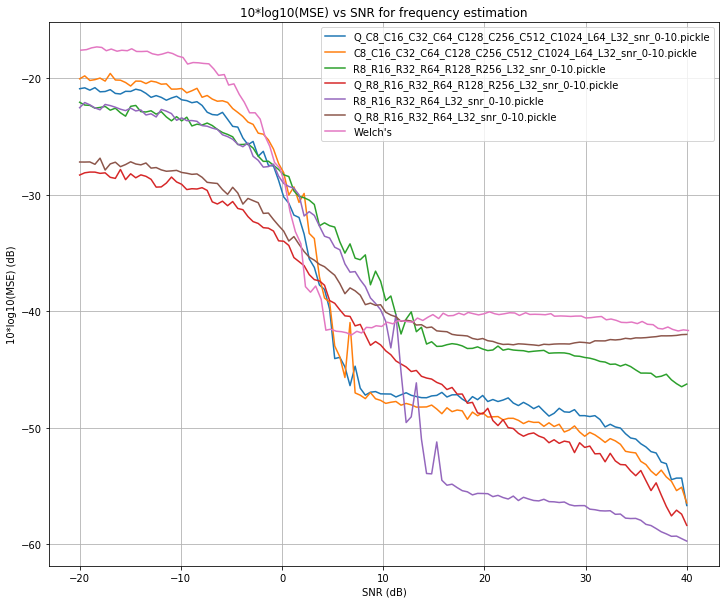

Graph for n=32
42


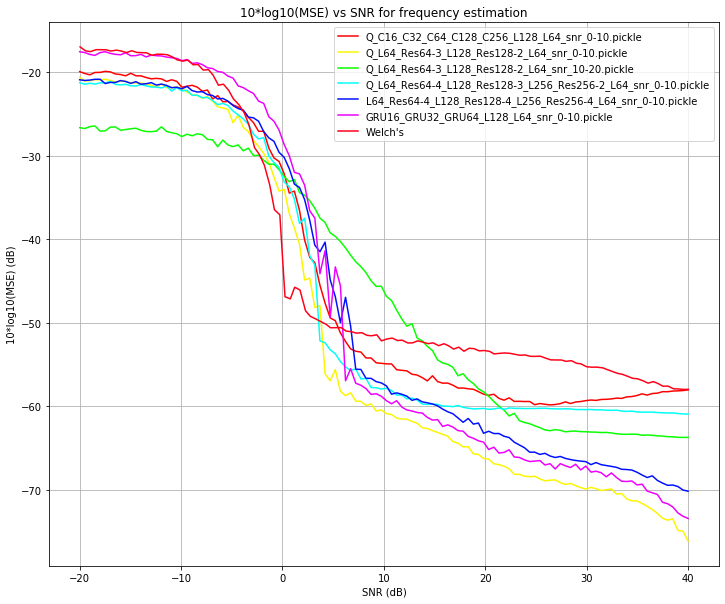

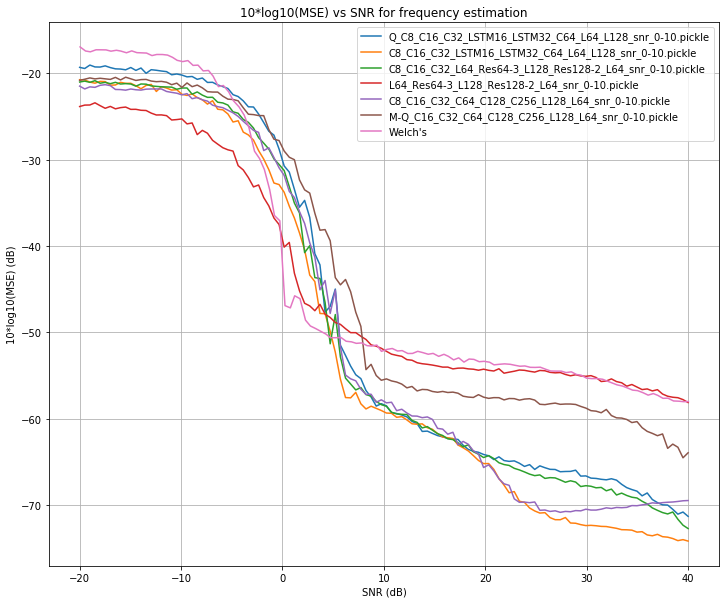

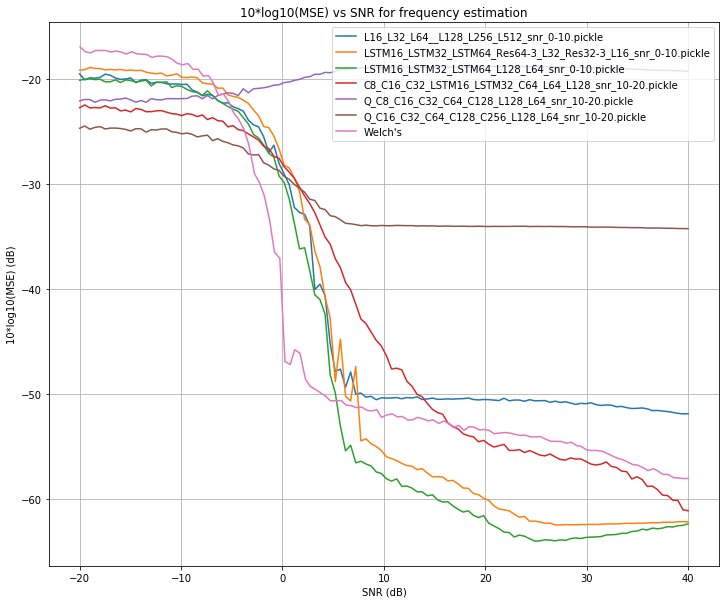

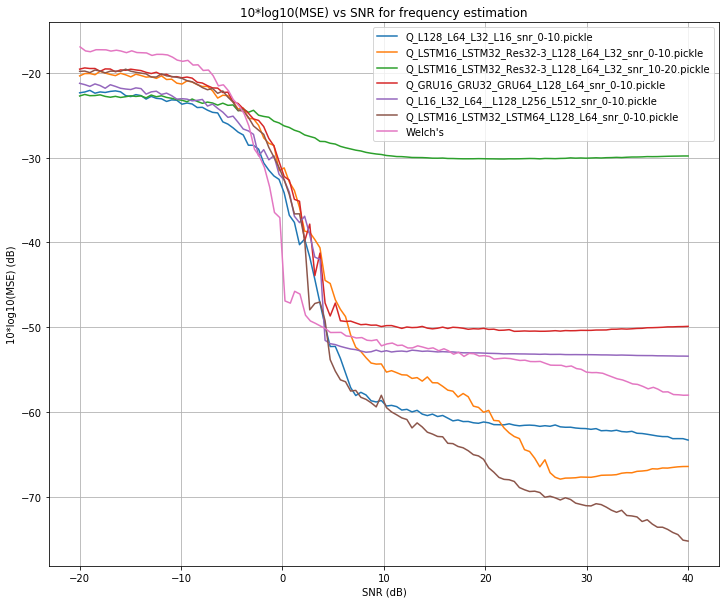

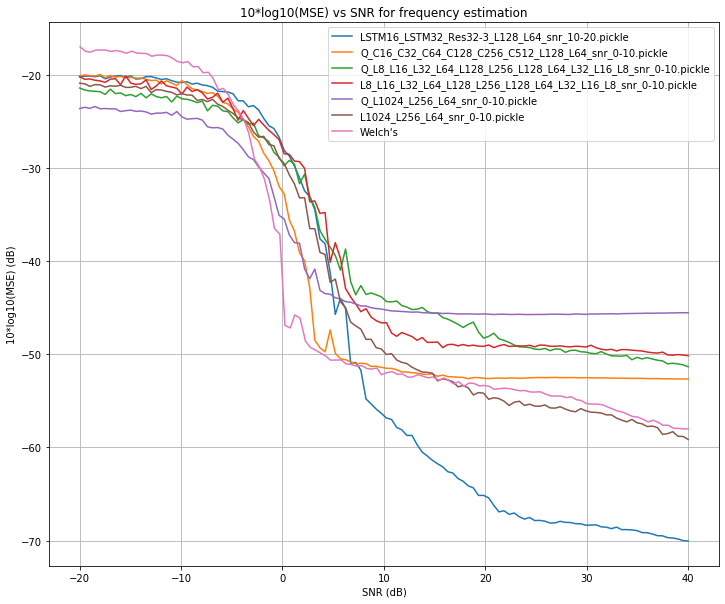

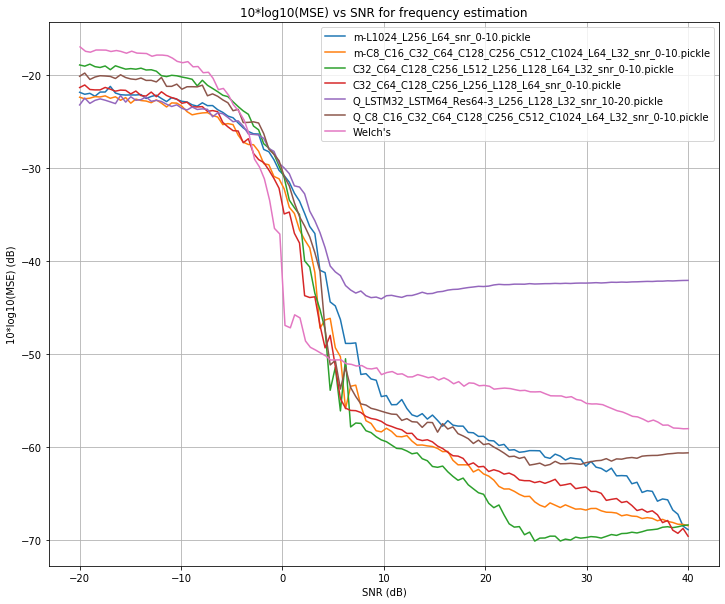

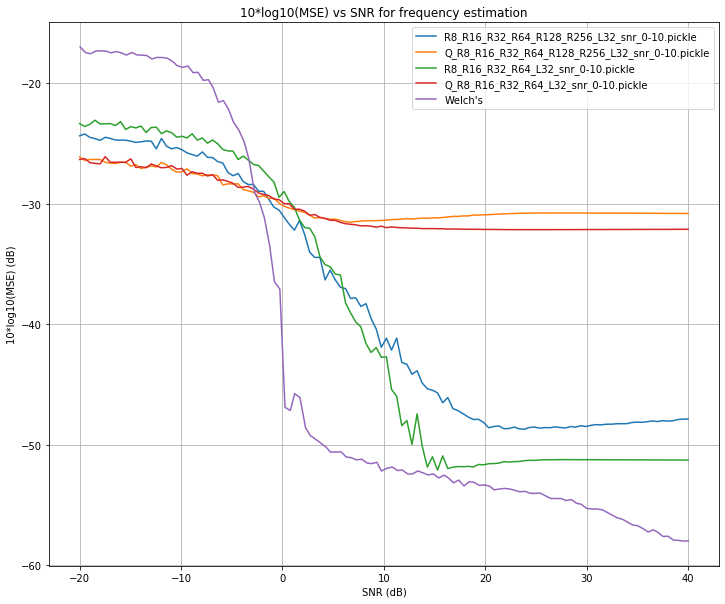

Graph for n=64
45


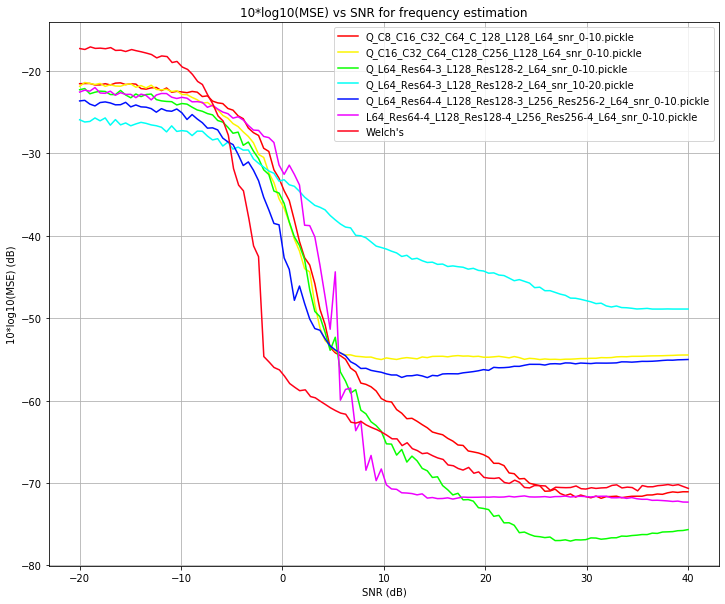

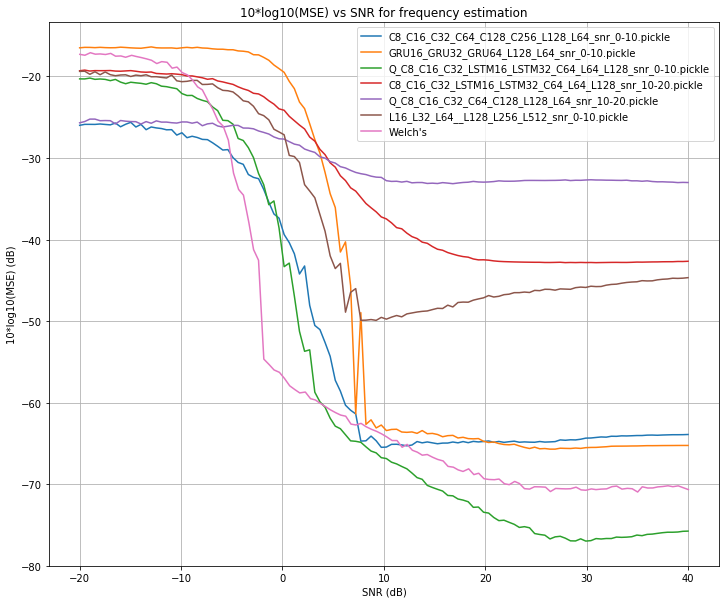

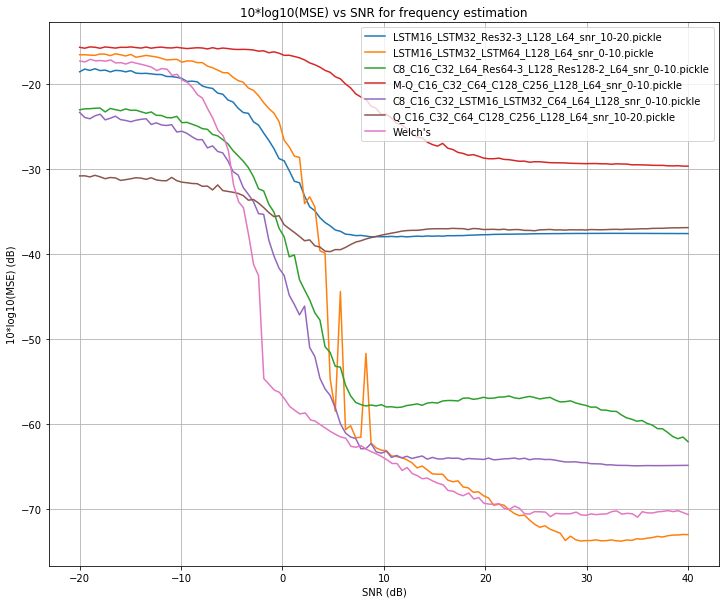

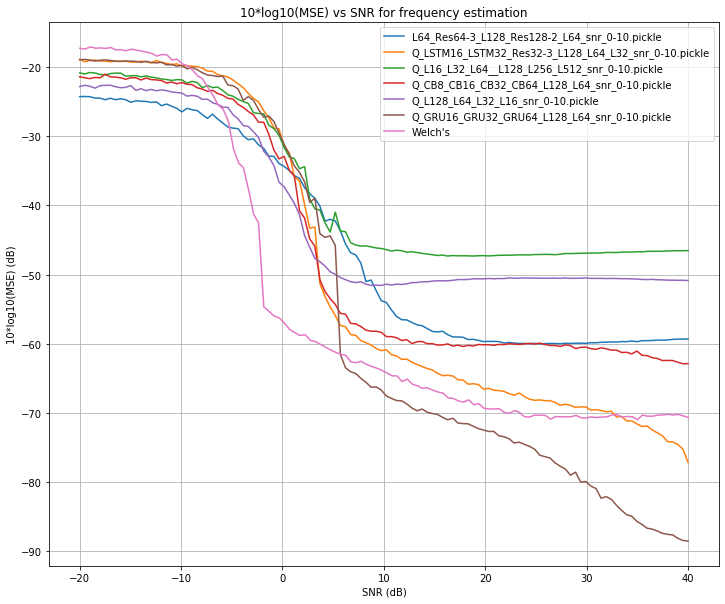

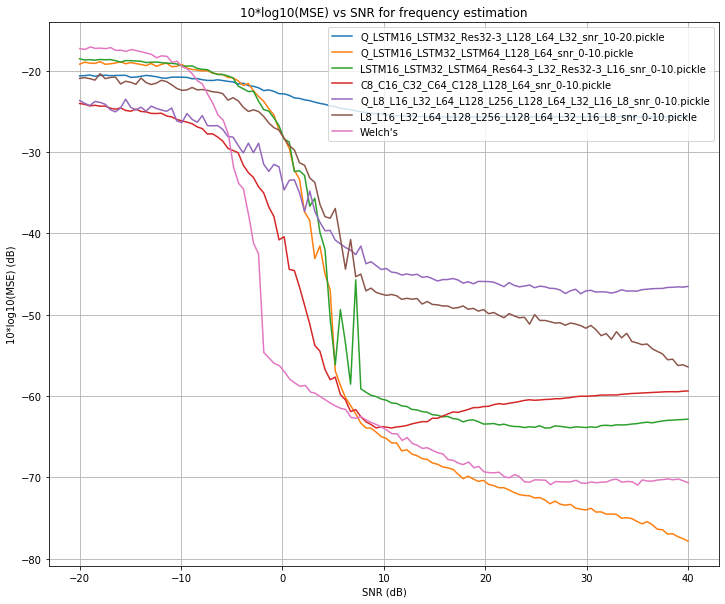

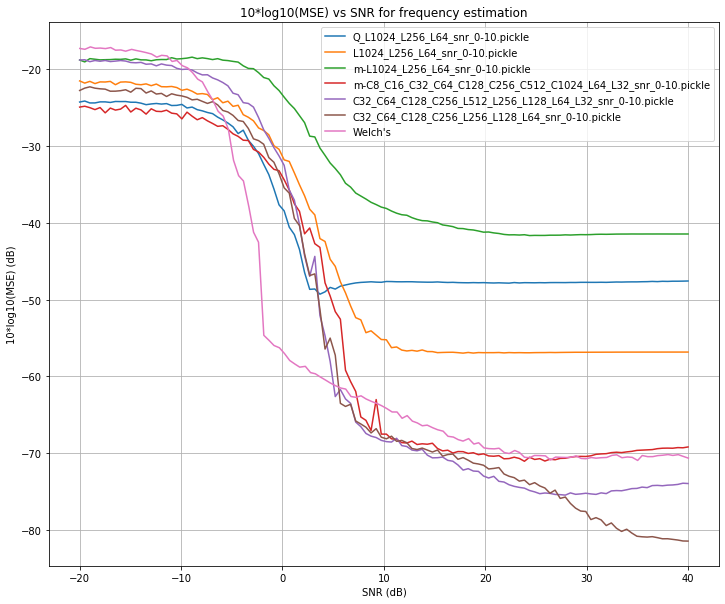

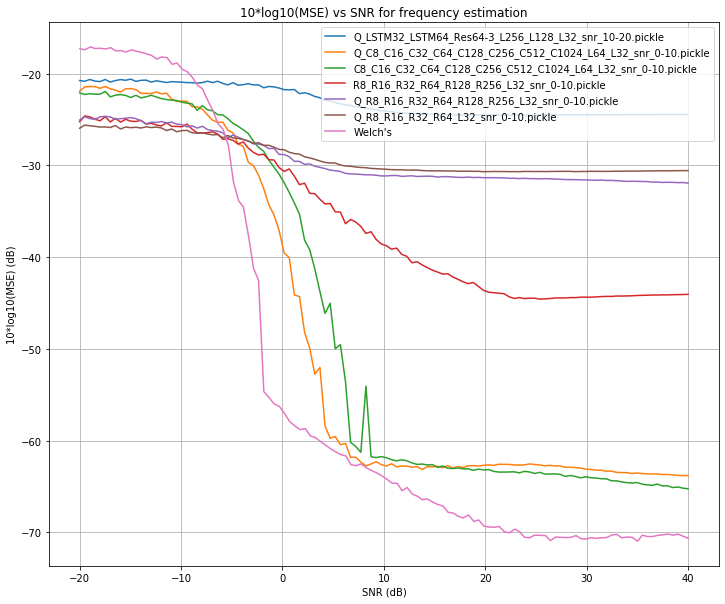

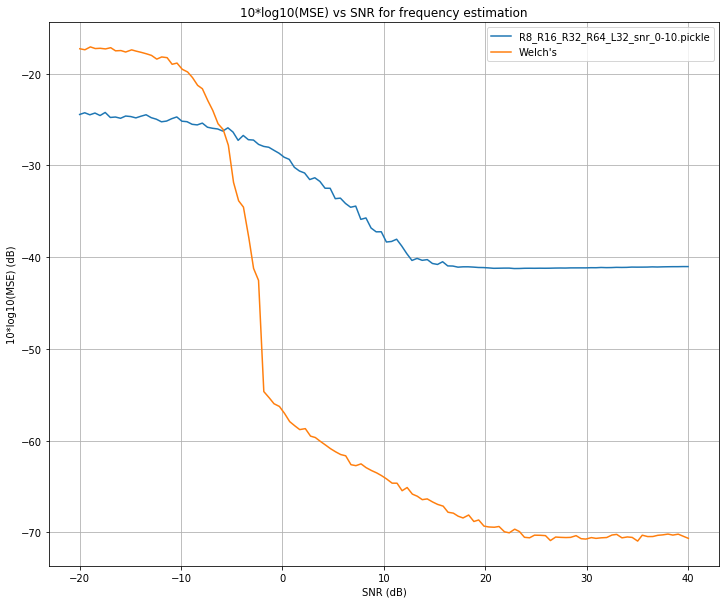

Graph for n=128
37


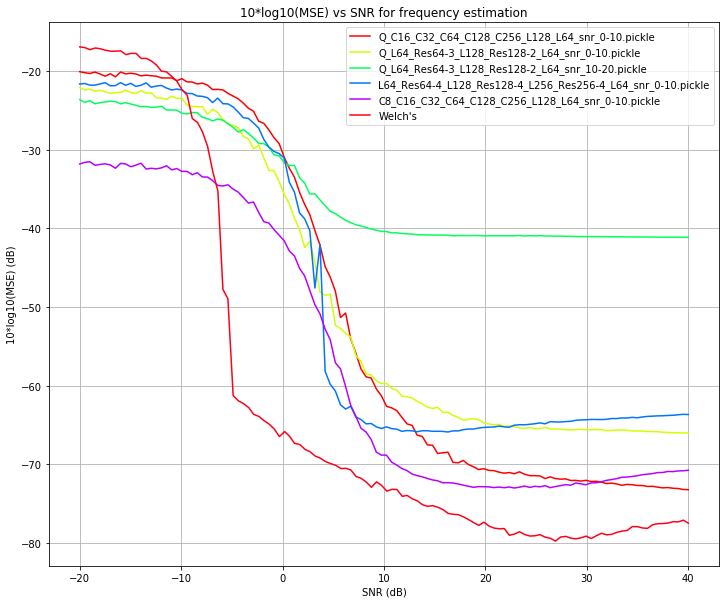

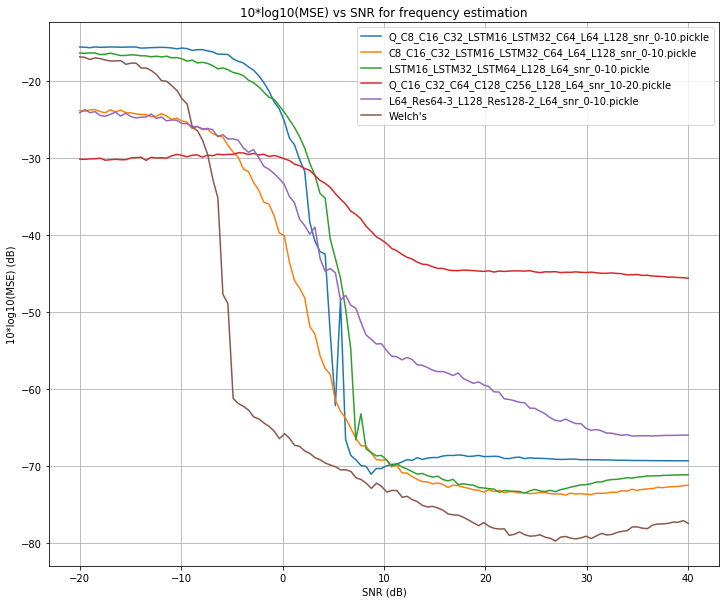

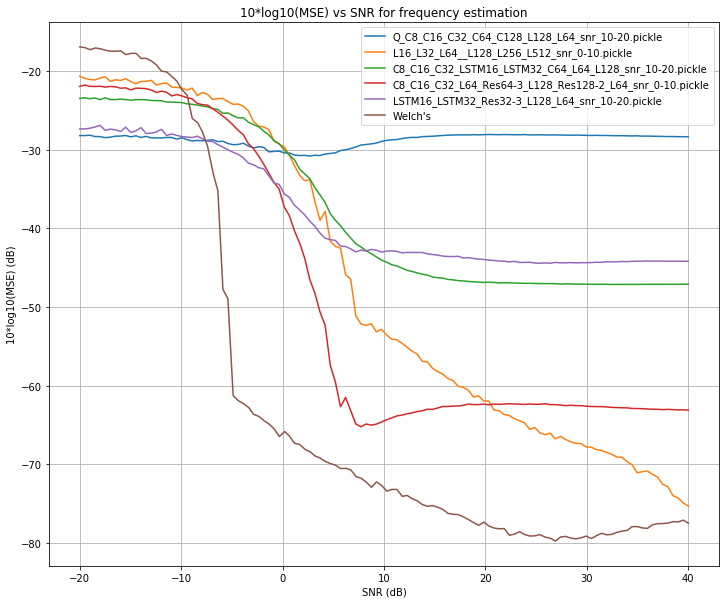

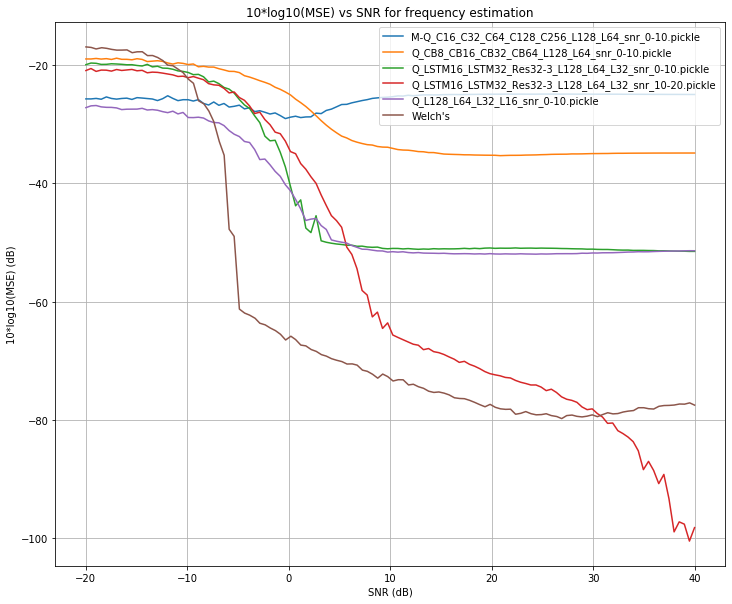

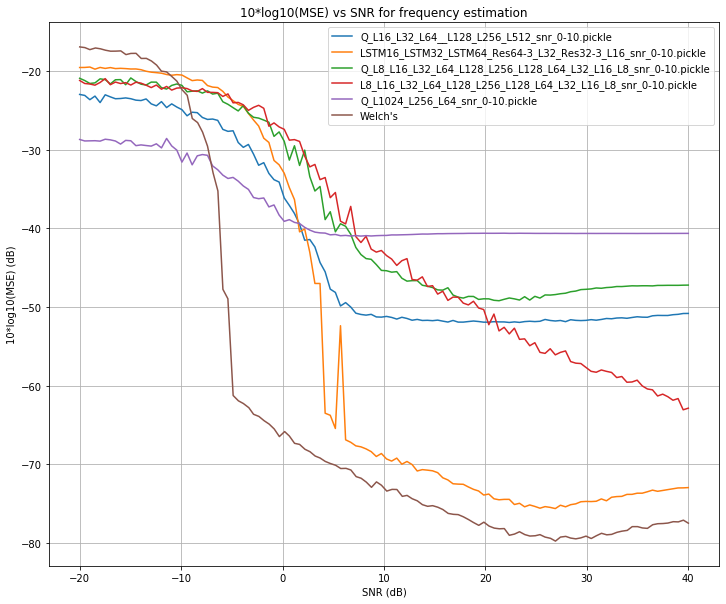

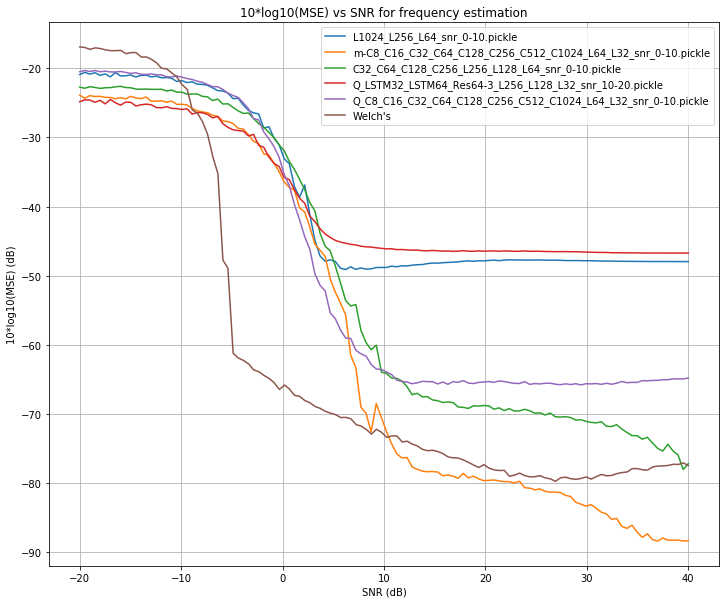

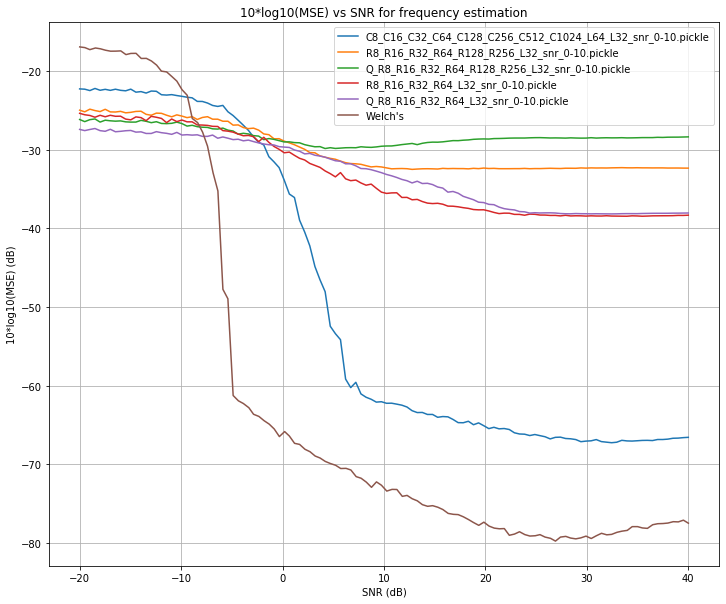

In [0]:
import os

cmap = matplotlib.cm.get_cmap('hsv')

plt.rcParams.update({'font.size': 10})

nset = [8, 16, 32, 64, 128]
# nset = [8]

main_path = 'drive/My Drive/Colab Notebooks_UT/CFO/MSES/'
# base_names = ["Periodogram", "Weighted Phase Averager", "Unweighted Phase Averager", "Weighted Linear", "Unweighted Linear"]
# use classic_names instead

## set up plotting
matplotlib.rcParams['figure.figsize'] = [12, 10]
periodogram_sel = 1

for ni in nset:

    used = []
    count = 0
    print(f"Graph for n={ni}")
    msepath = 'drive/My Drive/Colab Notebooks_UT/CFO/MSES/' + str(ni) + "-point/"

    classic_path = msepath +'classic.pickle'
    filen = open(classic_path, "rb") 
    (snrs, mses), (quant_snrs, quant_mses) = pickle.load(filen)
    # print(np.array(quant_mses).shape)
    filen.close()
    welch_periodogram = [quant_snrs, quant_mses[periodogram_sel]]

    estimators = os.listdir(msepath)
    estimators.remove('classic.pickle')


    print(len(estimators))
    plots = 6.0
    maximum = len(estimators)//plots
    ncolors = np.linspace(0, 1, maximum)
    colors = cmap(ncolors)
    fig, ax = plt.subplots()
    ax.set_prop_cycle(color=colors)

    # remove the phase difference mses
    toremove = []
    for estimator in estimators:
        if estimator[0] == 'P':
            # print(estimator)
            toremove.append(estimator)

    [estimators.remove(toremove[i]) for i in range(len(toremove))]

        
    for estimator in estimators:   
        filen = open(msepath+estimator, "rb")
        try:
            (snrs, mses), (quant_snrs, quant_mses) = pickle.load(filen)
        except EOFError as e:
            print(estimator)
        filen.close()
        
        if estimator=='classic.pickle':
            count += 1
            for i in range(1):
                plt.plot(quant_snrs[i], quant_mses[i])
                used.append(base_names[i])
        else:
            count += 1
            plt.plot(quant_snrs.reshape(120, 1), quant_mses.reshape(120, 1))
            used.append(estimator)

        if count >= maximum-1:
            plt.plot(welch_periodogram[0], welch_periodogram[1])
            used.append(classic_names[periodogram_sel])
            plt.legend(used, loc='upper right')
            # plt.xlim((-20, 50))
            # bot, top = plt.ylim()
            # plt.ylim((bot, 0))
            plt.title(f"10*log10(MSE) vs SNR for frequency estimation")
            plt.xlabel("SNR (dB)")
            plt.ylabel("10*log10(MSE) (dB)")
            plt.grid()
            plt.show()
            count = 0
            used = []
            
    # estimators.remove('classic.pickle')
    # print(count, len(estimators))
    if len(used) >= 1:
        plt.plot(welch_periodogram[0], welch_periodogram[1])
        used.append(classic_names[periodogram_sel])  
        plt.legend(used, loc='upper right')
        # plt.xlim((-20, 50))
        # bot, top = plt.ylim()
        # plt.ylim((bot, 0))
        plt.title(f"10*log10(MSE) vs SNR for frequency estimation")
        plt.xlabel("SNR (dB)")
        plt.ylabel("10*log10(MSE) (dB)")
        plt.grid()
        plt.show()

## Specific Plotting

Graph for n=8
41 41


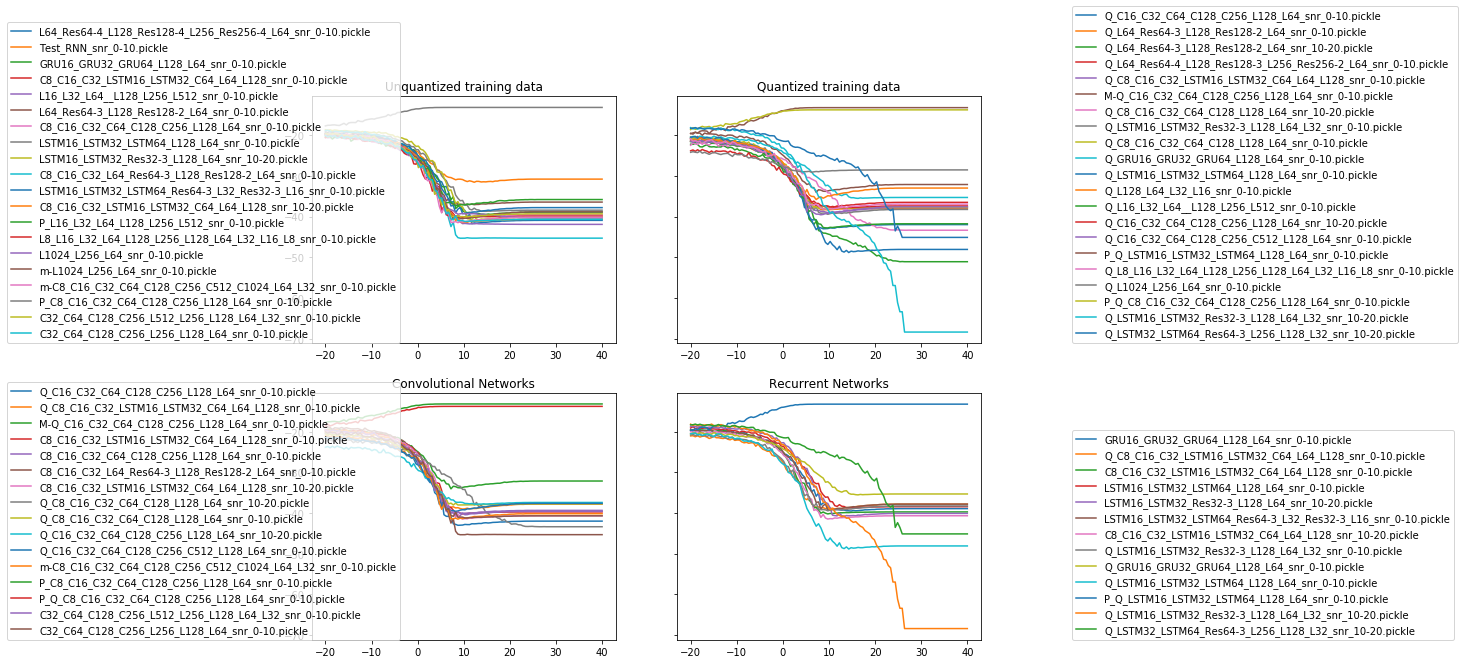

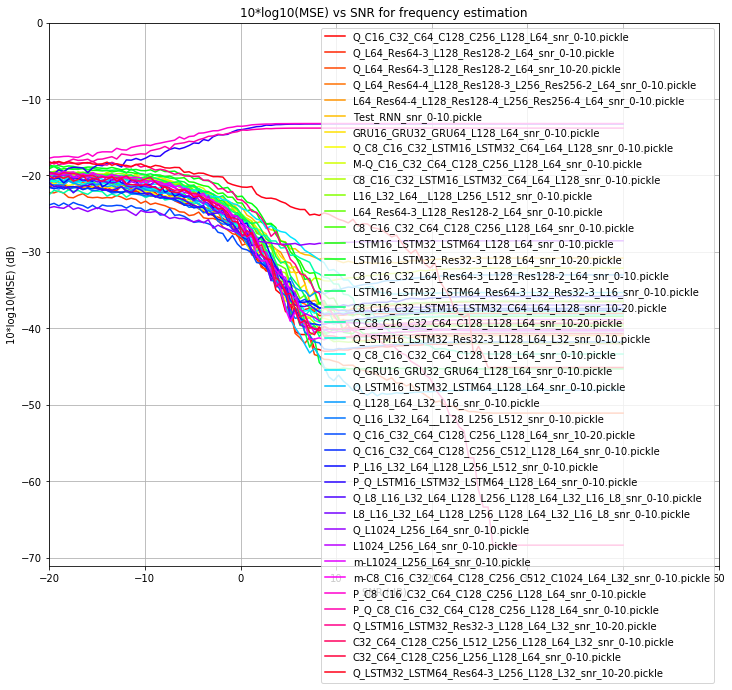

In [0]:
# specific plotting

import os

cmap = matplotlib.cm.get_cmap('hsv')

nset = [8, 16, 32] #, 16, 32, 64, 128]

main_path = 'drive/My Drive/Colab Notebooks_UT/CFO/MSES/'


## set up plotting
matplotlib.rcParams['figure.figsize'] = [12, 10]

for ni in nset:
    fig, axes = plt.subplots(2, 2, sharey=True)
    # subplots for unquantized, quantized, Conv, and one for RNN
    names = [[], [], [], []]
    axes[0][0].title.set_text("Unquantized training data")
    axes[0][1].title.set_text("Quantized training data")
    axes[1][0].title.set_text("Convolutional Networks")x
    axes[1][1].title.set_text("Recurrent Networks")

    count = 0
    print(f"Graph for n={ni}")
    msepath = 'drive/My Drive/Colab Notebooks_UT/CFO/MSES/' + str(ni) + "-point/"
    estimators = os.listdir(msepath)
    estimators.remove('classic.pickle')
    ncolors = np.linspace(0, 1, len(estimators))
    colors = cmap(ncolors)
    fig, ax = plt.subplots()
    ax.set_prop_cycle(color=colors)
        
    for estimator in estimators:   
        filen = open(msepath+estimator, "rb")
        (snrs, mses), (quant_snrs, quant_mses) = pickle.load(filen)
        filen.close()
        
        if estimator=='classic.pickle':
            for i in range(len(mses)):
                plt.plot(quant_snrs, quant_mses[i])
        else:
            count += 1
            if "Q" not in estimator:
                axes[0][0].plot(quant_snrs.reshape(120, 1), quant_mses.reshape(120, 1))
                names[0].append(estimator)
                axes[0][0].legend(names[0], loc=(-1, 0))

            else:
                axes[0][1].plot(quant_snrs.reshape(120, 1), quant_mses.reshape(120, 1))
                names[1].append(estimator)
                axes[0][1].legend(names[1], loc=(1.3, 0))

            if "C" in estimator:
                axes[1][0].plot(quant_snrs.reshape(120, 1), quant_mses.reshape(120, 1))
                names[2].append(estimator)
                axes[1][0].legend(names[2], loc=(-1, 0))

            if "LSTM" in estimator or "GRU" in estimator:
                axes[1][1].plot(quant_snrs.reshape(120, 1), quant_mses.reshape(120, 1))
                names[3].append(estimator)
                axes[1][1].legend(names[3], loc=(1.3, 0))

            plt.plot(quant_snrs.reshape(120, 1), quant_mses.reshape(120, 1))
            
    # estimators.remove('classic.pickle')
    print(count, len(estimators))
    plt.legend(estimators, loc='upper right')
    plt.xlim((-20, 50))
    bot, top = plt.ylim()
    plt.ylim((bot, 0))
    plt.title(f"10*log10(MSE) vs SNR for frequency estimation")
    plt.xlabel("SNR (dB)")
    plt.ylabel("10*log10(MSE) (dB)")
    plt.grid()
    plt.show()

# Best Results

Graph for n=8


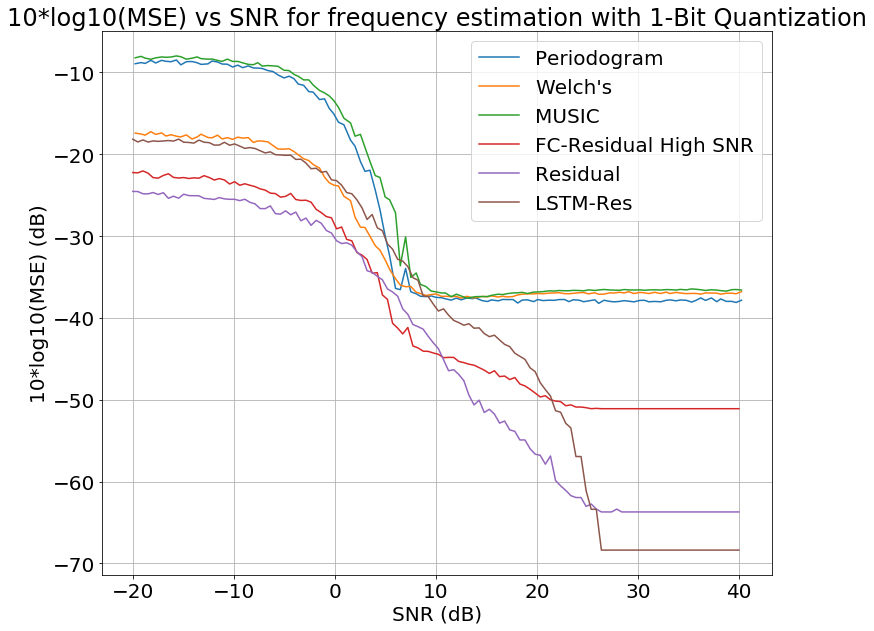

Graph for n=16


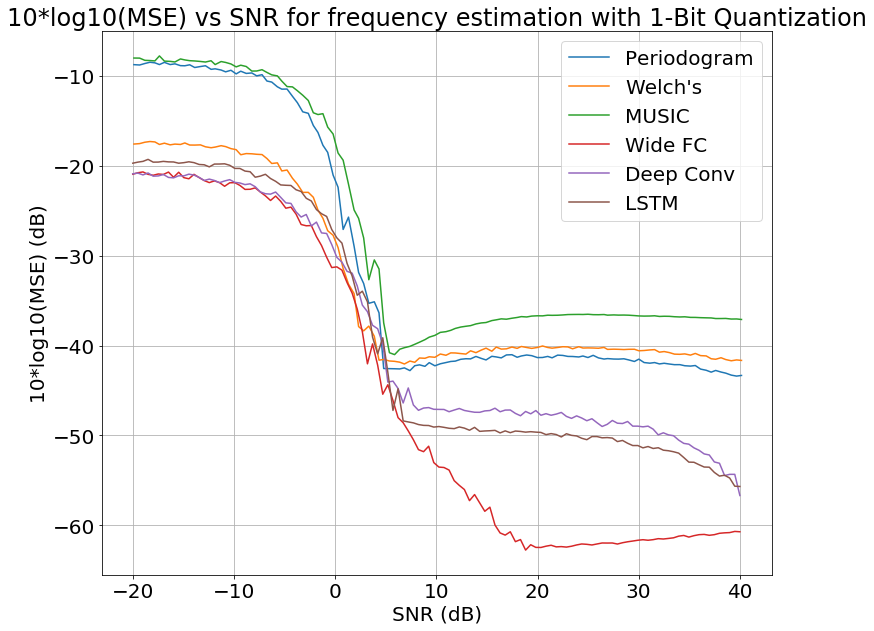

Graph for n=32


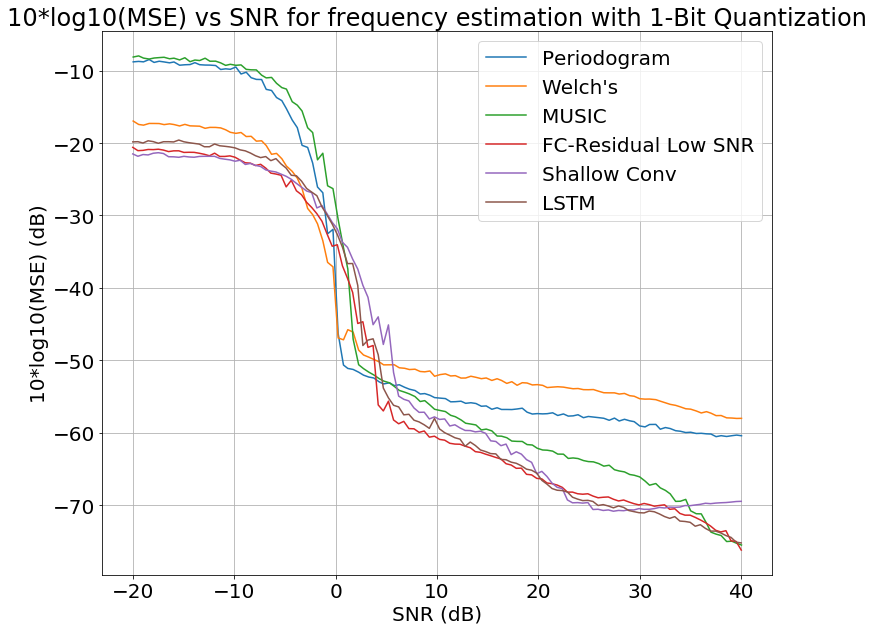

Graph for n=64


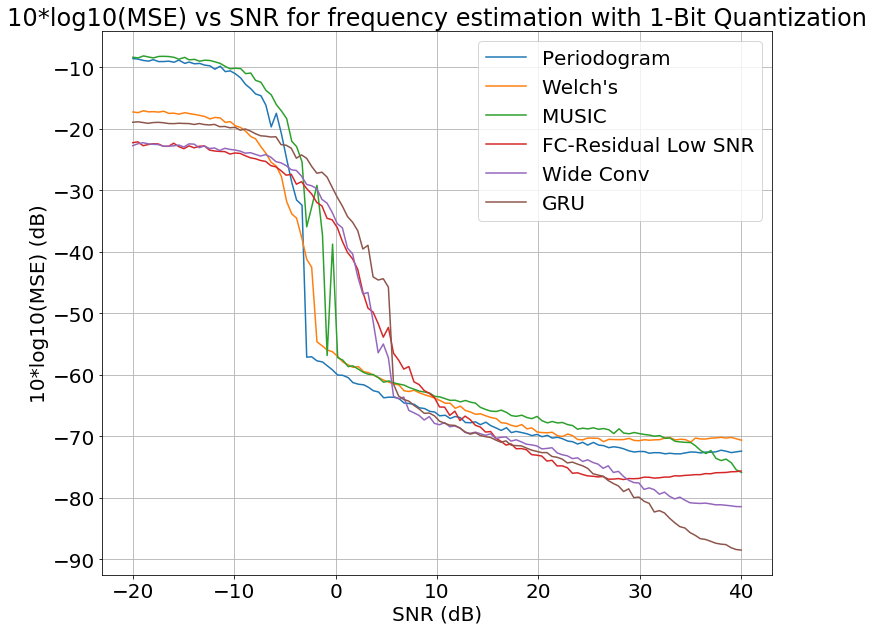

Graph for n=128


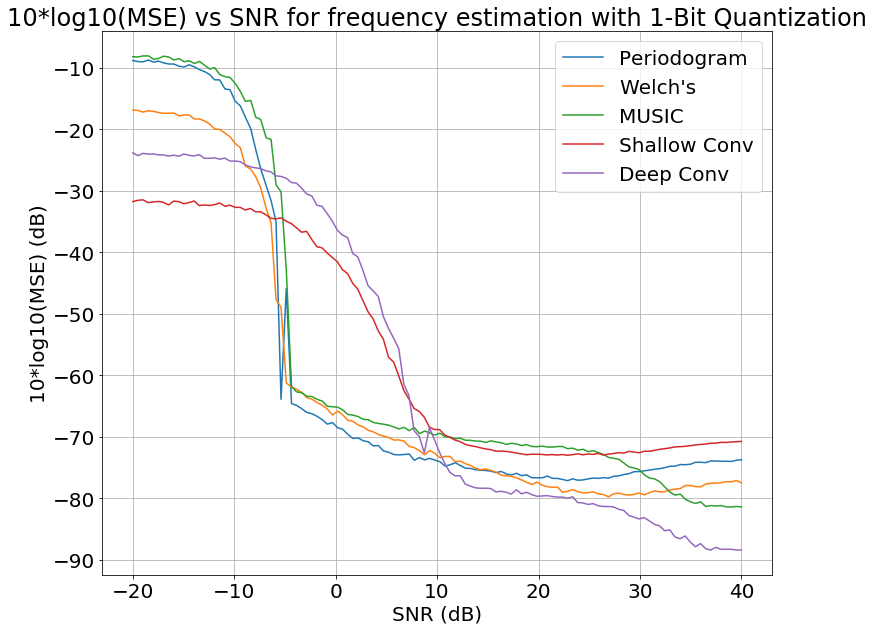

In [0]:
nset = [8, 16, 32, 64, 128]

main_path = 'drive/My Drive/Colab Notebooks_UT/CFO/MSES/'
base_names = ["Periodogram"]

classic_est = ["welchs-rect", "welchs-rect", "periodogram/welchs-rect", "Welchs", "Welchs"]

DL_est = [
          ['Q_L64_Res64-3_L128_Res128-2_L64_snr_10-20.pickle',
           'Q_R8_R16_R32_R64_L32_snr_0-10.pickle',
           'Q_LSTM16_LSTM32_Res32-3_L128_L64_L32_snr_10-20.pickle'],
          
          ['m-L1024_L256_L64_snr_0-10.pickle',
           'Q_C8_C16_C32_C64_C128_C256_C512_C1024_L64_L32_snr_0-10.pickle',
           'LSTM16_LSTM32_LSTM64_L128_L64_snr_0-10.pickle'],
          
          ['Q_L64_Res64-3_L128_Res128-2_L64_snr_0-10.pickle',
           'C8_C16_C32_C64_C128_C256_L128_L64_snr_0-10.pickle',
           'Q_LSTM16_LSTM32_LSTM64_L128_L64_snr_0-10.pickle'],
          
          ['Q_L64_Res64-3_L128_Res128-2_L64_snr_0-10.pickle',
           'C32_C64_C128_C256_L256_L128_L64_snr_0-10.pickle',
           'Q_GRU16_GRU32_GRU64_L128_L64_snr_0-10.pickle'],
          
          ['C8_C16_C32_C64_C128_C256_L128_L64_snr_0-10.pickle',
           'm-C8_C16_C32_C64_C128_C256_C512_C1024_L64_L32_snr_0-10.pickle']
          ]

DL_names = [
    ['FC-Residual High SNR', 'Residual', 'LSTM-Res'],
    ['Wide FC', 'Deep Conv', 'LSTM'],
    ['FC-Residual Low SNR', 'Shallow Conv', 'LSTM'],
    ['FC-Residual Low SNR', 'Wide Conv', 'GRU'],
    ['Shallow Conv', 'Deep Conv'],
    ]


## set up plotting
matplotlib.rcParams['figure.figsize'] = [12, 10]

for i, ni in enumerate(nset):
    print(f"Graph for n={ni}")
    msepath = 'drive/My Drive/Colab Notebooks_UT/CFO/MSES/' + str(ni) + "-point/"
           
    filen = open(msepath+'classic.pickle', "rb")
    (snrs, mses), (quant_snrs, quant_mses) = pickle.load(filen)
    filen.close()
        
    for k in range(len(mses)):
        plt.plot(quant_snrs, quant_mses[k])

    # plt.plot(quant_snrs, quant_mses[periodogram_sel])
        
    for estimator in DL_est[i]:
        filen = open(msepath+estimator, "rb")
        (snrs, mses), (quant_snrs, quant_mses) = pickle.load(filen)
        filen.close()
        
        plt.plot(quant_snrs.reshape(120, 1), quant_mses.reshape(120, 1))
            
    plt.legend(classic_names + DL_names[i])
    plt.title(f"10*log10(MSE) vs SNR for frequency estimation with 1-Bit Quantization")
    plt.xlabel("SNR (dB)")
    plt.ylabel("10*log10(MSE) (dB)")
    plt.grid()
    plt.show()

In [0]:
classic_names

['Periodogram', "Welch's", 'MUSIC', 'CRB']

In [0]:
number = 5
cmap = plt.get_cmap('gnuplot')
colors = [cmap(i) for i in np.linspace(0, 1, number)]

for i, color in enumerate(colors, start=1):
    plt.plot(x, i * x + i, color=color, label='$y = {i}x + {i}$'.format(i=i))
plt.legend(loc='best')
plt.show()

# Phase Dependence

PT_m-L1024_L256_L64_snr_0-10.h5py


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:309: ComplexWarning: Casting complex values to real discards the imaginary part


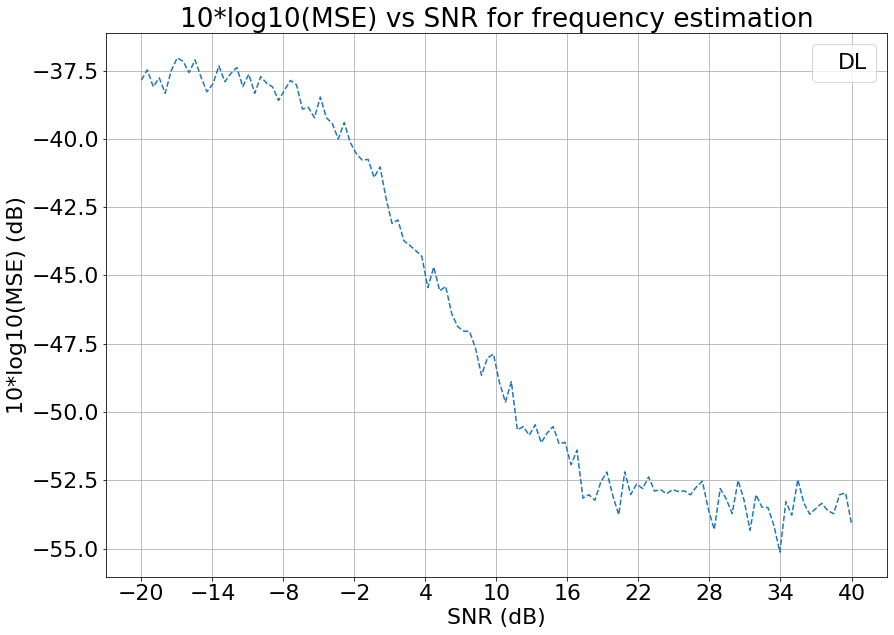

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:309: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:312: ComplexWarning: Casting complex values to real discards the imaginary part


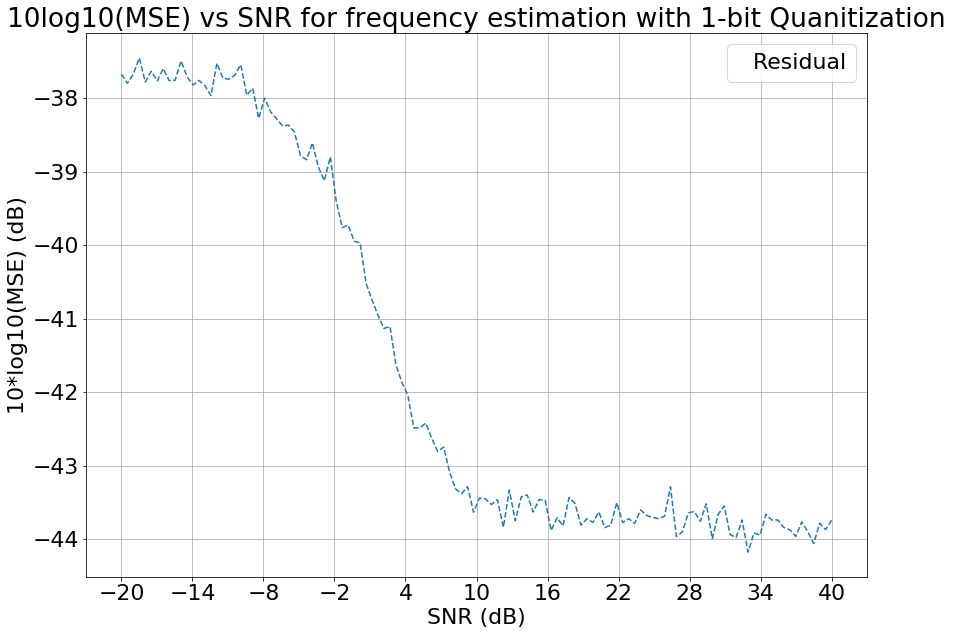

Saving to drive/My Drive/Colab Notebooks_UT/CFO/MSES/16-point/P_PT_m-L1024_L256_L64_snr_0-10.pickle


In [0]:
n = 16
quant = False
saver = True

mod1 = 'm-L1024_L256_L64_snr_0-10.h5py'
mod2 = 'C8_C16_C32_C64_C128_C256_L128_L64_snr_0-10.h5py'
mod3 = 'LSTM16_LSTM32_LSTM64_L128_L64_snr_0-10.h5py'
mod4 = 'C8_R16_R32_R64_R128_R256_L128_L64_snr_0-10.h5py'

mod5 = 'Q_m-L1024_L256_L64_snr_0-10.h5py'
mod6 = 'Q_C8_C16_C32_C64_C128_C256_L128_L64_snr_0-10.h5py'
mod7 = 'Q_LSTM16_LSTM32_LSTM64_L128_L64_snr_0-10.h5py'
mod8 = 'Q_C8_R16_R32_R64_R128_R256_L128_L64_snr_0-10.h5py'
mod9 = 'PT_m-L1024_L256_L64_snr_0-10.h5py'
mod_names = [mod1, mod2, mod3, mod4, mod5, mod6, mod7, mod8]
mod_names = [mod9]

for i in range(1):
    if quant == True:
        mod_names[i] = 'Q_' + mod_names[i]

    print(mod_names[i])
    model_path = 'drive/My Drive/Colab Notebooks_UT/CFO/Models/'+str(n)+'-point/'
    model_name = model_path + mod_names[i]

    model = keras.models.load_model(model_name)

    def multi_est_model(data):
        data = np.array(data)
        # model1 = keras.models.load_model(model_name1)
        datam = np.array([])
        for i in range(len(data)):
            datam = np.append(datam, convert_complex_to_real(data[i]))
        results = model.predict(datam.reshape(len(data), n, 2))
        # del model1
        return results

    x, _ = data_generator(min_fc=fc, max_fc=fc, amplitude=amplitude, n=n, fs=fs)

    (dlsnrs, dlmses) = plot_over_snr_DL(x, -20, 40, fs=fs, min_fc=min_fc, max_fc=max_fc, phase=True, estimators=[multi_est_model], names=["DL"], monte_carlos=200)
    (quant_dlsnrs, quant_dlmses) = plot_over_snr_DL(x, -20, 40, fs=fs, min_fc=min_fc, max_fc=max_fc, phase=True, estimators=[multi_est_model], names=["Residual"], quantizer=linear_quantizer, bits=bits, monte_carlos=1200)
            
    if saver is True:
        classic_mse = 'drive/My Drive/Colab Notebooks_UT/CFO/MSES/'+str(n)+'-point/'+'P_'+ mod_names[i][:-4]+'pickle'
        print("Saving to", classic_mse)
        filen = open(classic_mse, "wb")
        pickle.dump([(dlsnrs, dlmses), (quant_dlsnrs, quant_dlmses)], filen )
        filen.close()
        



In [0]:
# want to plot 4 sets of 2 estimators
ANN_name = 'm-L1024_L256_L64_snr_0-10.pickle'
CNN_name = 'C8_C16_C32_C64_C128_C256_L128_L64_snr_0-10.pickle'
RNN_name = 'LSTM16_LSTM32_LSTM64_L128_L64_snr_0-10.pickle'
Res_name = 'C8_R16_R32_R64_R128_R256_L128_L64_snr_0-10.pickle'

ANN_name2 = 'PT_m-L1024_L256_L64_snr_0-10.pickle'
CNN_name2 = 'PT_C8_C16_C32_C64_C128_C256_L128_L64_snr_0-10.pickle'
RNN_name2 = 'P_LSTM16_LSTM32_LSTM64_L128_L64_snr_0-10.pickle'
Res_name2 = 'P_C8_R16_R32_R64_R128_R256_L128_L64_snr_0-10.pickle'

markset = [['rs:', 'bd:', 'g^:', 'kP:', 'rs-', 'bd-', 'g^-', 'kP-']]
estims = [ANN_name, CNN_name, RNN_name, Res_name, ANN_name2, CNN_name2, RNN_name2, Res_name2]
names = ["ANN", "CNN", "RNN", "Residual"]

nset_plot(estims, "NN MSE with Phase Offset", name=names, nset=[16], markerset=markset, classics=False)

NameError: ignored

# FC/CNN/RNN

### General Case

Using classics, make sure you have 7 markers


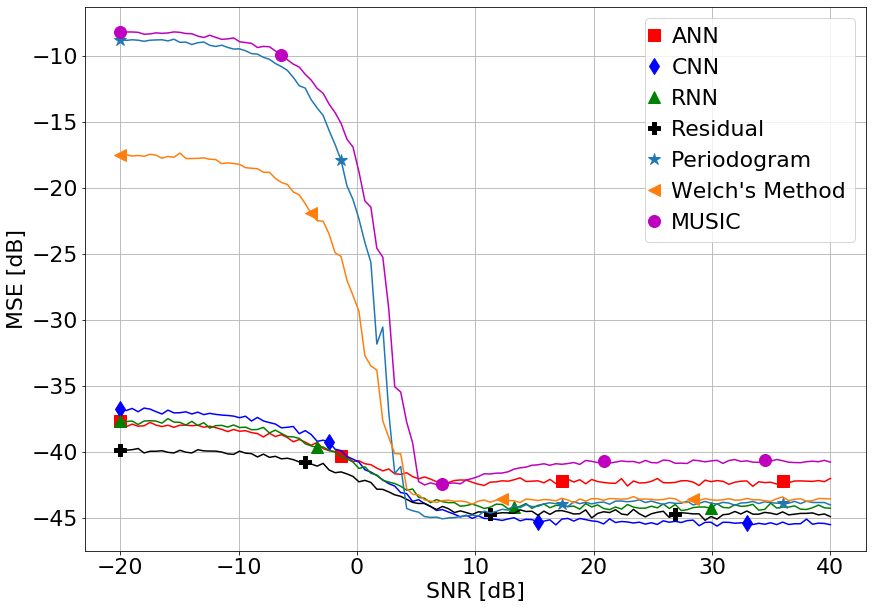

In [0]:
ANN_name = 'PT_Q_m-L1024_L256_L64_snr_0-10.pickle'
CNN_name = 'PT_Q_C8_C16_C32_C64_C128_C256_L128_L64_snr_0-10.pickle'
RNN_name = 'PT_Q_LSTM16_LSTM32_LSTM64_L128_L64_snr_0-10.pickle'
Res_name = 'PT_Q_C8_R16_R32_R64_R128_R256_L128_L64_snr_0-10.pickle'

list_names3 = [ANN_name, CNN_name, RNN_name]
names3 = ["ANN", "CNN", "RNN"]
list_names4 = [ANN_name, CNN_name, RNN_name, Res_name]
names4 = ["ANN", "CNN", "RNN", "Residual"]
nset = [16]
markset = [['rs-', 'bd-', 'g^-', 'kP-', '*-', '<-', 'mo-']]

nset_plot(list_names4, "NN Estimators Compared to Classic Estimators", names4, nset=nset, markerset=markset, classics=True)

## Pilot Length

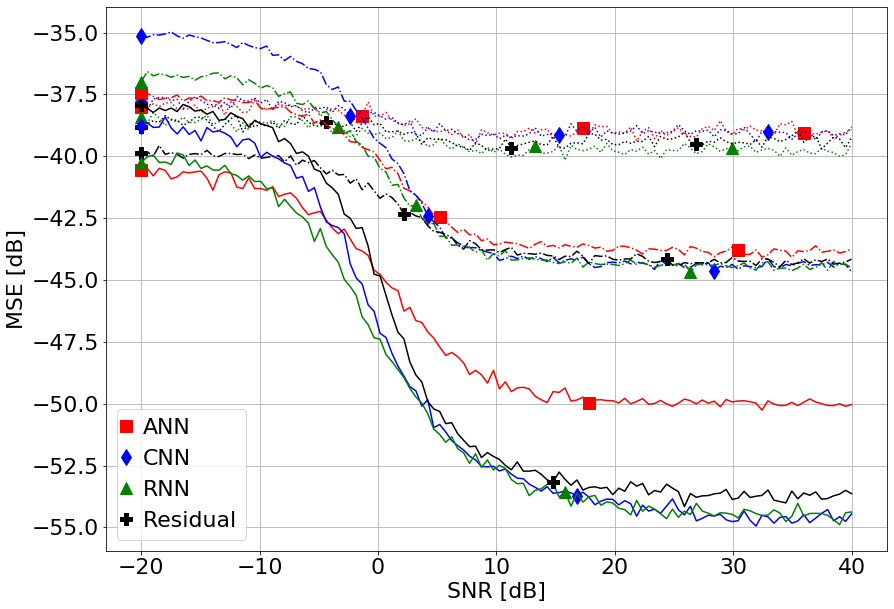

In [0]:
ANN_name = 'PT_m-L1024_L256_L64_snr_0-10.pickle'
CNN_name = 'PT_C8_C16_C32_C64_C128_C256_L128_L64_snr_0-10.pickle'
RNN_name = 'PT_LSTM16_LSTM32_LSTM64_L128_L64_snr_0-10.pickle'
Res_name = 'PT_C8_R16_R32_R64_R128_R256_L128_L64_snr_0-10.pickle'

list_names3 = [ANN_name, CNN_name, RNN_name]
names3 = ["ANN", "CNN", "RNN"]
list_names4 = [ANN_name, CNN_name, RNN_name, Res_name]
names4 = ["ANN", "CNN", "RNN", "Residual"]

markset = [['rs:', 'bd:', 'g^:', 'kP:'], ['rs-.', 'bd-.', 'g^-.', 'kP-.'], ['rs-', 'bd-', 'g^-', 'kP-']]

nset_plot(list_names4, "Unquant low SNR", names4, markerset=markset, classics=False)

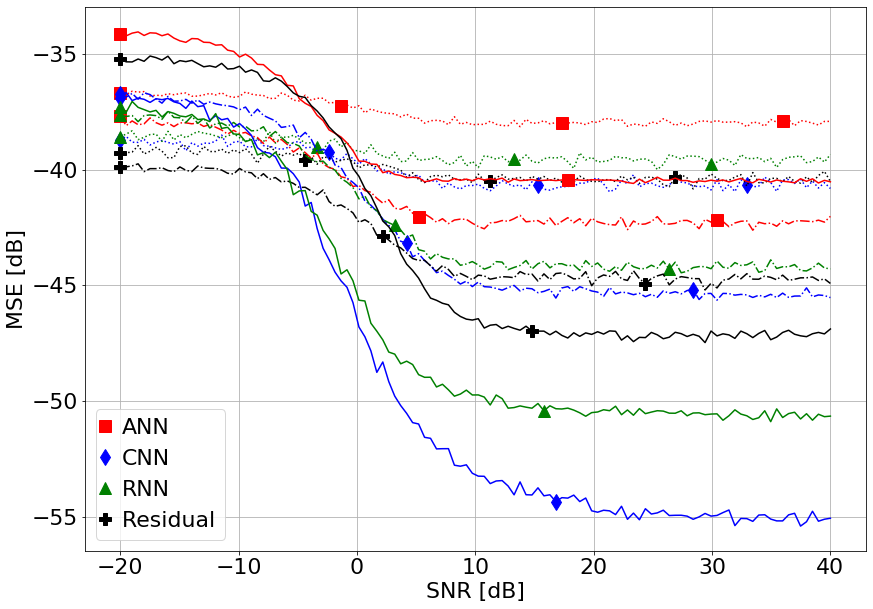

In [0]:
ANN_name = 'PT_Q_m-L1024_L256_L64_snr_0-10.pickle'
CNN_name = 'PT_Q_C8_C16_C32_C64_C128_C256_L128_L64_snr_0-10.pickle'
RNN_name = 'PT_Q_LSTM16_LSTM32_LSTM64_L128_L64_snr_0-10.pickle'
Res_name = 'PT_Q_C8_R16_R32_R64_R128_R256_L128_L64_snr_0-10.pickle'

list_names3 = [ANN_name, CNN_name, RNN_name]
names3 = ["ANN", "CNN", "RNN"]
list_names4 = [ANN_name, CNN_name, RNN_name, Res_name]
names4 = ["ANN", "CNN", "RNN", "Residual"]

markset = [['rs:', 'bd:', 'g^:', 'kP:'], ['rs-.', 'bd-.', 'g^-.', 'kP-.'], ['rs-', 'bd-', 'g^-', 'kP-']]

nset_plot(list_names4, "Quantized Low SNR", names4, markerset=markset, classics=False)

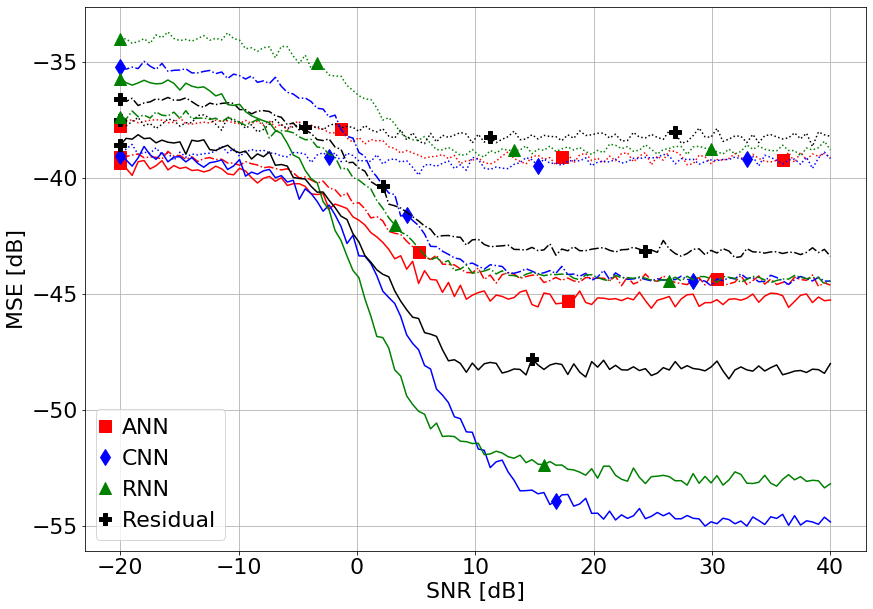

In [0]:
ANN_name = 'PT_m-L1024_L256_L64_snr_10-20.pickle'
CNN_name = 'PT_C8_C16_C32_C64_C128_C256_L128_L64_snr_10-20.pickle'
RNN_name = 'PT_LSTM16_LSTM32_LSTM64_L128_L64_snr_10-20.pickle'
Res_name = 'PT_C8_R16_R32_R64_R128_R256_L128_L64_snr_10-20.pickle'

list_names3 = [ANN_name, CNN_name, RNN_name]
names3 = ["ANN", "CNN", "RNN"]
list_names4 = [ANN_name, CNN_name, RNN_name, Res_name]
names4 = ["ANN", "CNN", "RNN", "Residual"]

markset = [['rs:', 'bd:', 'g^:', 'kP:'], ['rs-.', 'bd-.', 'g^-.', 'kP-.'], ['rs-', 'bd-', 'g^-', 'kP-']]

nset_plot(list_names4, "Unquant High SNR", names4, markerset=markset, classics=False)

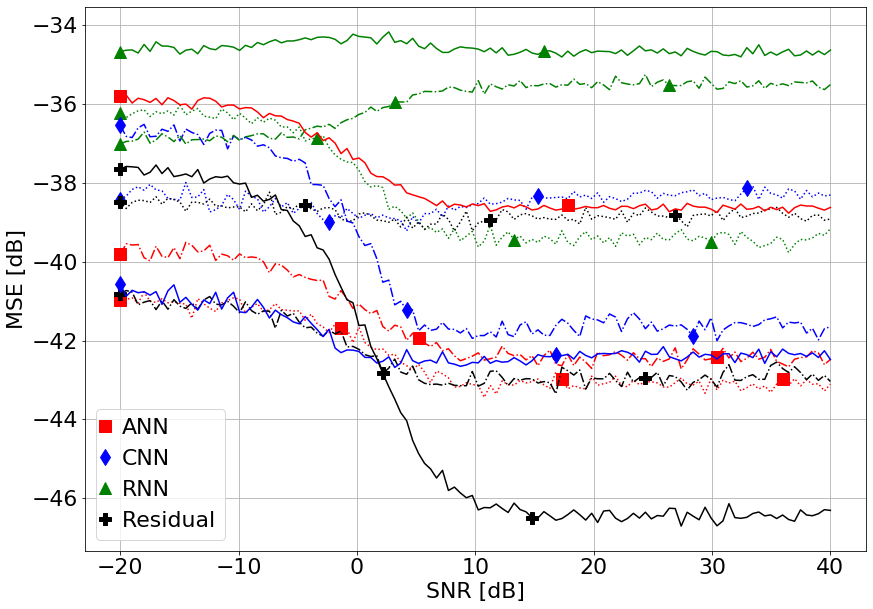

In [0]:
ANN_name = 'PT_Q_m-L1024_L256_L64_snr_10-20.pickle'
CNN_name = 'PT_Q_C8_C16_C32_C64_C128_C256_L128_L64_snr_10-20.pickle'
RNN_name = 'PT_Q_LSTM16_LSTM32_LSTM64_L128_L64_snr_10-20.pickle'
Res_name = 'PT_Q_C8_R16_R32_R64_R128_R256_L128_L64_snr_10-20.pickle'

list_names3 = [ANN_name, CNN_name, RNN_name]
names3 = ["ANN", "CNN", "RNN"]
list_names4 = [ANN_name, CNN_name, RNN_name, Res_name]
names4 = ["ANN", "CNN", "RNN", "Residual"]

markset = [['rs:', 'bd:', 'g^:', 'kP:'], ['rs-.', 'bd-.', 'g^-.', 'kP-.'], ['rs-', 'bd-', 'g^-', 'kP-']]

nset_plot(list_names4, "Quant High SNR", names4, markerset=markset, classics=False)

## Training SNR

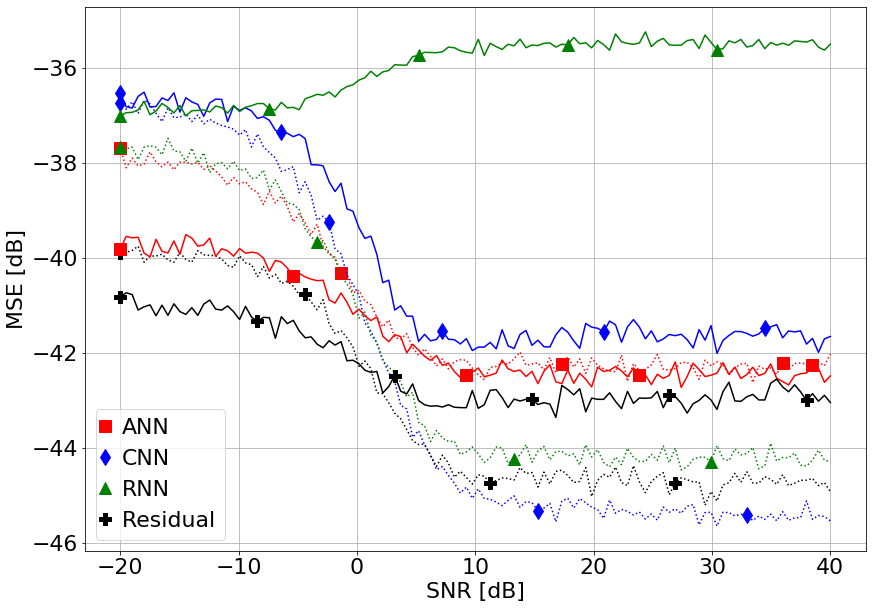

In [0]:
# want to plot 4 sets of 2 estimators
ANN_name = 'PT_Q_m-L1024_L256_L64_snr_0-10.pickle'
CNN_name = 'PT_Q_C8_C16_C32_C64_C128_C256_L128_L64_snr_0-10.pickle'
RNN_name = 'PT_Q_LSTM16_LSTM32_LSTM64_L128_L64_snr_0-10.pickle'
Res_name = 'PT_Q_C8_R16_R32_R64_R128_R256_L128_L64_snr_0-10.pickle'

ANN_name2 = 'PT_Q_m-L1024_L256_L64_snr_10-20.pickle'
CNN_name2 = 'PT_Q_C8_C16_C32_C64_C128_C256_L128_L64_snr_10-20.pickle'
RNN_name2 = 'PT_Q_LSTM16_LSTM32_LSTM64_L128_L64_snr_10-20.pickle'
Res_name2 = 'PT_Q_C8_R16_R32_R64_R128_R256_L128_L64_snr_10-20.pickle'

markset = [['rs:', 'bd:', 'g^:', 'kP:', 'rs-', 'bd-', 'g^-', 'kP-']]
estims = [ANN_name, CNN_name, RNN_name, Res_name, ANN_name2, CNN_name2, RNN_name2, Res_name2]
names = ["ANN", "CNN", "RNN", "Residual"]

nset_plot(estims, "NN MSE with Low and High SNR Training", name=names, nset=[16], markerset=markset, classics=False)

## Quantization

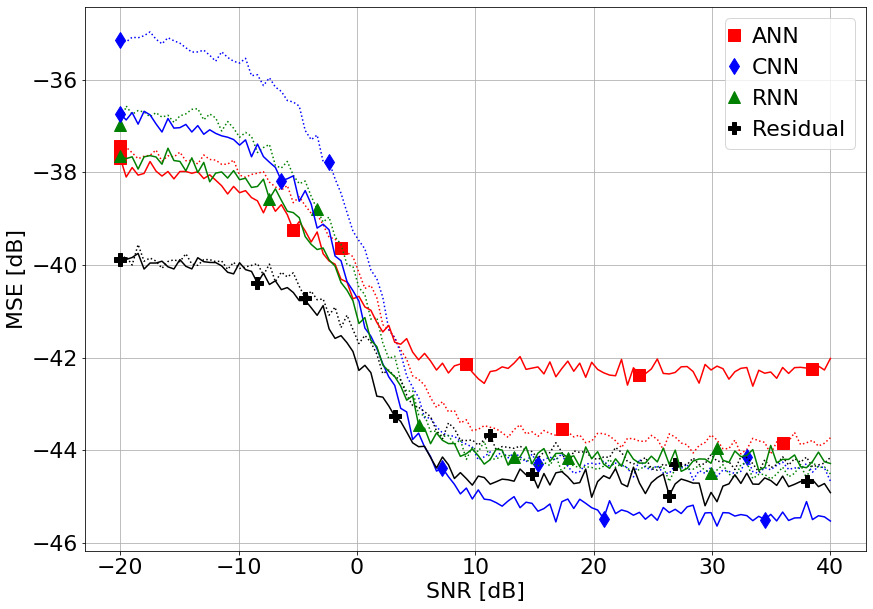

In [0]:
# want to plot 4 sets of 2 estimators
ANN_name = 'PT_m-L1024_L256_L64_snr_0-10.pickle'
CNN_name = 'PT_C8_C16_C32_C64_C128_C256_L128_L64_snr_0-10.pickle'
RNN_name = 'PT_LSTM16_LSTM32_LSTM64_L128_L64_snr_0-10.pickle'
Res_name = 'PT_C8_R16_R32_R64_R128_R256_L128_L64_snr_0-10.pickle'

ANN_name2 = 'PT_Q_m-L1024_L256_L64_snr_0-10.pickle'
CNN_name2 = 'PT_Q_C8_C16_C32_C64_C128_C256_L128_L64_snr_0-10.pickle'
RNN_name2 = 'PT_Q_LSTM16_LSTM32_LSTM64_L128_L64_snr_0-10.pickle'
Res_name2 = 'PT_Q_C8_R16_R32_R64_R128_R256_L128_L64_snr_0-10.pickle'

markset = [['rs:', 'bd:', 'g^:', 'kP:', 'rs-', 'bd-', 'g^-', 'kP-']]

estims = [ANN_name, CNN_name, RNN_name, Res_name, ANN_name2, CNN_name2, RNN_name2, Res_name2]
names = ["ANN", "CNN", "RNN", "Residual"]

nset_plot(estims, "NN Performance with Quantized/Unquantized Training", name=names, nset=[16], markerset=markset)

# Test Area

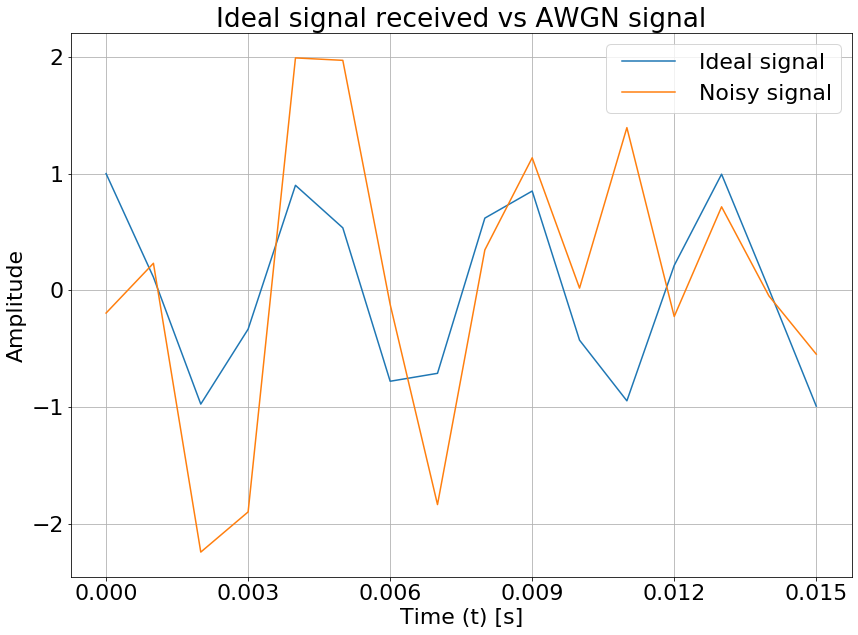

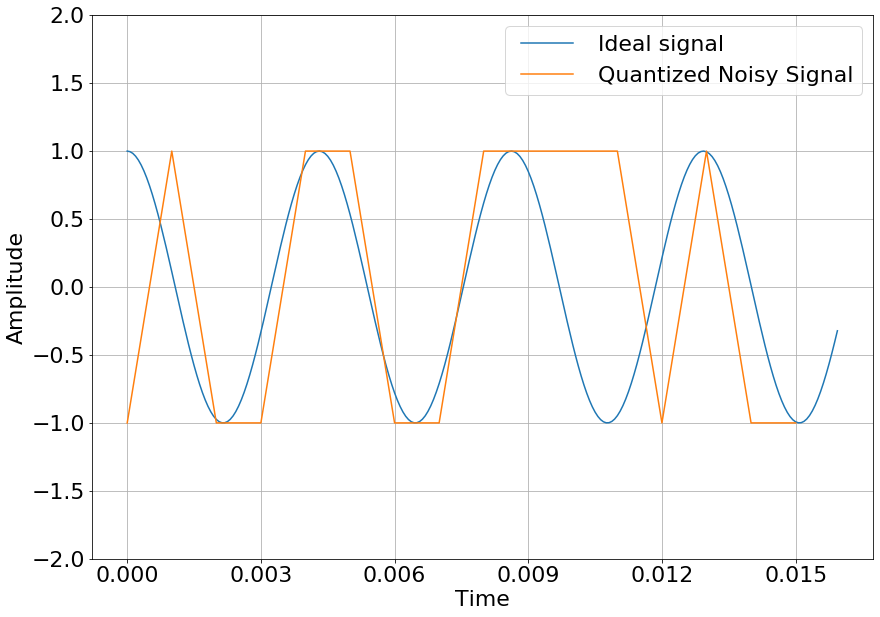

In [0]:
plt.rcParams.update({'legend.handlelength': 3})
plt.rcParams.update({'legend.numpoints': 3})
n = 16

# generate some ideal data
t = np.arange(0, n)/fs
x, _ = data_generator(min_fc=fc, max_fc=fc, amplitude=amplitude, n=n, fs=fs)
x2, _ = data_generator(min_fc=fc+0.2, max_fc=fc+0.2, amplitude=amplitude/2, n=n, fs=fs, phase_offset=30)

SNR = -5
# add noise
x_rec, std = generate_noise(x, SNR)
x_rec2, std = generate_noise(x, SNR)
# print(f"snr ={10**(calc_snr(x, x_rec)/10.0)}, also A^2/2o^2 = {amplitude**2/(2*std**2)}")

# quantize values
linear_x, _ = general_quantizer(x_rec, bits=bits, maximum=amplitude, minimum=-amplitude)
linear_x2, _ = general_quantizer(x_rec2, bits=1, minimum=-amplitude/2, maximum=amplitude/2)

# plot for comparison
plt.plot(t, x.real, t, x_rec.real)
plt.title("Ideal signal received vs AWGN signal")
plt.xticks(np.arange(0, t[-1]+1e-8, step=0.2*t[-1]))
plt.xlabel("Time (t) [s]")
plt.ylabel("Amplitude")
plt.legend(["Ideal signal", "Noisy signal"], loc="best")
plt.grid()
plt.show()

x_high, _ = data_generator(min_fc=fc, max_fc=fc, amplitude=amplitude, n=16*n, fs=fs*16)
t2 = np.arange(0, 16*n)/(fs*16)

plt.plot(t2, x_high.real, t, linear_x.real)
# plt.title("Ideal Signal vs Quantized Noisy Signal")
plt.xticks(np.arange(0, t[-1]+1e-8, step=0.2*t[-1]))
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.legend(["Ideal signal", "Quantized Noisy Signal"], loc="best")
plt.ylim((-2, 2))
plt.grid()
plt.show()

plt.rcParams.update({'font.size': 22})
plt.rcParams.update({'legend.handlelength': 0})
plt.rcParams.update({'legend.numpoints': 1})

LPT_C8_C16_C32_C64_C128_C256_L128_L64_snr_0-10.h5py


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:309: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:312: ComplexWarning: Casting complex values to real discards the imaginary part


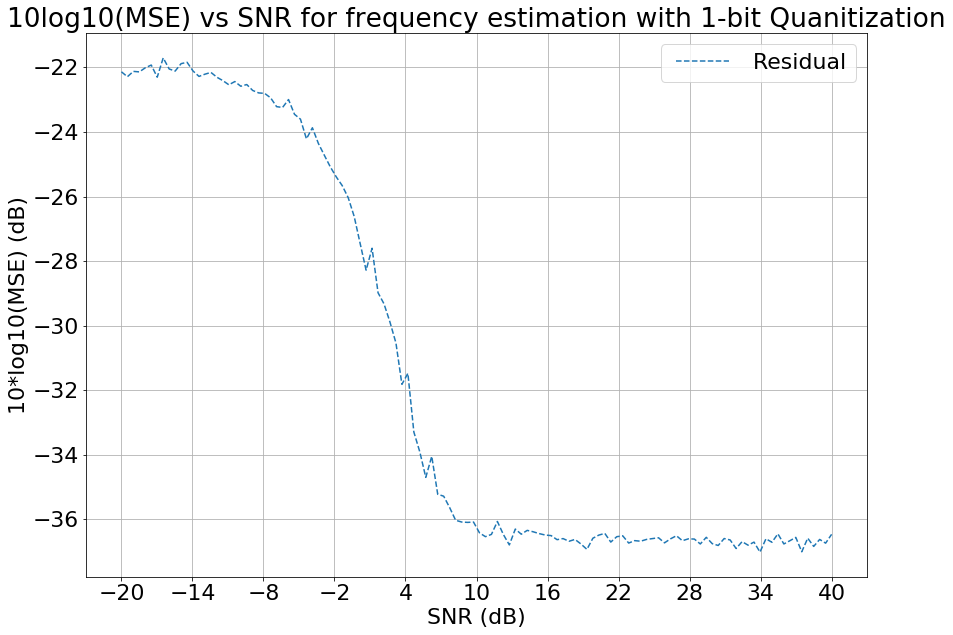

In [0]:
n = 16
quant = False

mod1 = 'PT_m-L1024_L256_L64_snr_0-10.h5py'
mod2 = 'PT_C8_C16_C32_C64_C128_C256_L128_L64_snr_0-10.h5py'
mod3 = 'PT_LSTM16_LSTM32_LSTM64_L128_L64_snr_0-10.h5py'
mod4 = 'PT_C8_R16_R32_R64_R128_R256_L128_L64_snr_0-10.h5py'
mod5 = 'PT_m-L1024_L256_L64_snr_10-20.h5py'
mod6 = 'PT_C8_C16_C32_C64_C128_C256_L128_L64_snr_10-20.h5py'
mod7 = 'PT_LSTM16_LSTM32_LSTM64_L128_L64_snr_10-20.h5py'
mod8 = 'PT_C8_R16_R32_R64_R128_R256_L128_L64_snr_10-20.h5py'
mod9 = 'PT_Q_m-L1024_L256_L64_snr_0-10.h5py'
mod10 = 'PT_Q_C8_C16_C32_C64_C128_C256_L128_L64_snr_0-10.h5py'
mod11 = 'PT_Q_LSTM16_LSTM32_LSTM64_L128_L64_snr_0-10.h5py'
mod12 = 'PT_Q_C8_R16_R32_R64_R128_R256_L128_L64_snr_0-10.h5py'

mod13 = 'LPT_C8_C16_C32_C64_C128_C256_L128_L64_snr_0-10.h5py'

# mod_names = [mod1, mod2, mod3, mod4]
mod_names = [mod1, mod2, mod3, mod4, mod5, mod6, mod7, mod8, mod9, mod10, mod11, mod12]
mod_names = [mod13]

for i in range(len(mod_names)):
    if quant == True:
        mod_names[i] = 'Q_' + mod_names[i]

    print(mod_names[i])
    model_path = 'drive/My Drive/Colab Notebooks_UT/CFO/Models/'+str(n)+'-point/'
    model_name = model_path + mod_names[i]

    model = keras.models.load_model(model_name)

    def multi_est_model(data):
        data = np.array(data)
        # model1 = keras.models.load_model(model_name1)
        datam = np.array([])
        for i in range(len(data)):
            datam = np.append(datam, convert_complex_to_real(data[i]))
        results = model.predict(datam.reshape(len(data), n, 2))
        # del model1
        return results

    x, _ = data_generator(min_fc=100, max_fc=130, amplitude=amplitude, n=n, fs=fs)

    (quant_dlsnrs, quant_dlmses) = plot_over_snr_DL(x, -20, 40, fs=fs, min_fc=100, max_fc=130, estimators=[multi_est_model], phase=True, names=["Residual"], quantizer=linear_quantizer, bits=bits, monte_carlos=600)
